#  Simple tool to analyze data from www.data.gouv.fr

**Note:** This is a Jupyter notebook which is also available as its executable export as a Python 3 script (therefore with automatically generated comments).

# Libraries

In [1]:
# Sys import
import sys, os, re
# Common imports
import math
import numpy             as NP
import numpy.random      as RAND
import scipy.stats       as STATS
from scipy import sparse
from scipy import linalg

# Better formatting functions
from IPython.display import display, HTML
from IPython import get_ipython

import matplotlib        as MPL
import matplotlib.pyplot as PLT
import seaborn as SNS
SNS.set(font_scale=1)

# Python programming
from itertools import cycle
from time import time
import datetime

# Using pandas
import pandas as PAN
import xlrd

In [2]:
import warnings
warnings.filterwarnings('ignore')
print("For now, reduce python warnings, I will look into this later")

For now, reduce python warnings, I will look into this later


### Import my own modules
The next cell attempts to give user some information if things improperly setup.
Intended to work both in Jupyter and when executing the Python file directly.

In [3]:
if not get_ipython() is None and os.path.abspath("../source/") not in sys.path:
    sys.path.append(os.path.abspath("../source/"))
try:
    from lib.utilities     import *
    from lib.figureHelpers import *
    from lib.DataMgrJSON   import *
    from lib.DataMgr       import *
    import lib.basicDataCTE as DCTE
except Exception as err:
    print("Could not find library 'lib' with contents 'DataGouvFr' ")
    if get_ipython() is None:
        print("Check the PYTHONPATH environment variable which should point to 'source' wich contains 'lib'")
    else:
        print("You are supposed to be running in JupySessions, and '../source/lib' should exist")
    raise err

Loaded lib
For now, reduce python warnings, I will look into this later


## Check environment

It is expected that:
- your working directory is named `JupySessions`, 
- that it has subdirectories 
   - `images/*` where generated images may be stored to avoid overcrowding. 
- At the same level as your working dir there should be directories 
   - `../data` for storing input data and 
   - `../source` for python scripts.
   
My package library is in `../source/lib`, and users running under Python (not in Jupyter) should
set their PYTHONPATH to include "../source" ( *or whatever appropriate* ).

In [4]:
checkSetup(chap="Chap01")
ImgMgr = ImageMgr(chapdir="Chap01")

# Load Data

## Functions

## Load CSV and XLSX data from remote 
The `dataFileVMgr` will manage a cache of data files in `../data`, the data will be downloaded
from www.data.gouv.fr using a request for datasets with badge '`covid-19`' if a more recent
version is present on the remote site. The meta information is stored/cached  in `../data/.data`
as the pickle of a json.

We check what is in the cache/data directory; for each file, we identify the latest version, 
and list this below to make sure. The file name will usually contain a time stamp; this has to do with 
the version management/identification technique used when downloading from www.data.gouv.fr.

For the files used in this notebook, the latest version is used/loaded irrespective of the
timestamp used in the notebook.

In [5]:
dataFileVMgr = manageAndCacheDataFilesFRDG("../data")
dataFileVMgr.getRemoteInfo()
dataFileVMgr.updatePrepare()
dataFileVMgr.cacheUpdate()

Need to reload cache from remote,  stale after 26h 24m 16s
URL/request=https://www.data.gouv.fr/api/1/datasets/?badge=covid-19&page=0&page_size=30
	Status:200:ok
Stored pickle in ../data/.cache.json
Skipping 'Population présente avant et après le début du confinement' fmt:None mod:2020-04-16T12:08:56.978000 org='institut-national-de-la-statistique-et-des-etudes-economiques-insee'
About to load file ../data/donnees-hospitalieres-covid19-2020-06-08-19h00.csv, available space is 26393744
Wrote file 	'../data/donnees-hospitalieres-covid19-2020-06-08-19h00.csv'
	from URL:'https://www.data.gouv.fr/fr/datasets/r/63352e38-d353-4b54-bfd1-f1b3ee1cabd7'
About to load file ../data/donnees-hospitalieres-nouveaux-covid19-2020-06-08-19h00.csv, available space is 25563351
Wrote file 	'../data/donnees-hospitalieres-nouveaux-covid19-2020-06-08-19h00.csv'
	from URL:'https://www.data.gouv.fr/fr/datasets/r/6fadff46-9efd-4c53-942a-54aca783c30c'
About to load file ../data/donnees-hospitalieres-classe-age-cov

In [6]:
print("Most recent versions of files in data directory:")
for f in dataFileVMgr.listMostRecent() :
    print(f"\t{f}")

Most recent versions of files in data directory:
	donnees-hospitalieres-classe-age-covid19-2020-06-08-19h00.csv
	donnees-hospitalieres-covid19-2020-06-08-19h00.csv
	donnees-hospitalieres-etablissements-covid19-2020-06-08-19h00.csv
	donnees-hospitalieres-nouveaux-covid19-2020-06-08-19h00.csv
	donnees-tests-covid19-labo-hebdomadaire-2020-05-27-19h00.csv
	donnees-tests-covid19-labo-quotidien-2020-05-29-19h00.csv
	sursaud-covid19-hebdomadaire-2020-05-27-19h00.csv
	sursaud-covid19-quotidien-2020-06-08-19h00-departement.csv
	sursaud-covid19-quotidien-2020-06-08-19h00-france.csv
	sursaud-covid19-quotidien-2020-06-08-19h00-region.csv
	sursaud-covid19-quotidien-2020-06-08-19h00.xlsx


In [7]:
last = lambda x: dataFileVMgr.getRecentVersion(x,default=True)

This ensures we load the most recent version, so that it is not required to update the list 
below. The timestamps shown in the following sequence will be update by the call to `getRecentVersion`.

In [8]:
dailyDepCsv    = last("sursaud-covid19-quotidien-2020-04-11-19h00-departement.csv")
dailyRegionCsv = last("sursaud-covid19-quotidien-2020-04-11-19h00-region.csv")
dailyFranceCsv = last("sursaud-covid19-quotidien-2020-04-12-19h00-france.csv")
dailyXlsx      = last("sursaud-covid19-quotidien-2020-04-12-19h00.xlsx")
weeklyCsv      = last("sursaud-covid19-hebdomadaire-2020-04-08-19h00.csv")

hospAgeCsv     = last("donnees-hospitalieres-classe-age-covid19-2020-04-11-19h00.csv")
hospNouveauCsv = last("donnees-hospitalieres-nouveaux-covid19-2020-04-11-19h00.csv")
hospCsv        = last("donnees-hospitalieres-covid19-2020-04-11-19h00.csv")
hospEtablCsv   = last("donnees-hospitalieres-etablissements-covid19-2020-04-12-19h00.csv")
weeklyLabCsv   = last("donnees-tests-covid19-labo-hebdomadaire-2020-04-16-10h47.csv")
dailyLabCsv    = last("donnees-tests-covid19-labo-quotidien-2020-04-17-19h00.csv")


S1 = set (dataFileVMgr.listMostRecent())
S2 =set((dailyDepCsv,dailyRegionCsv,dailyFranceCsv, dailyXlsx, weeklyCsv, 
         hospAgeCsv, hospNouveauCsv, hospCsv,  hospEtablCsv, weeklyLabCsv, dailyLabCsv  ))
missing = S1. difference(S2)
if len(missing) > 0:
    print (f"Missing comparing with most recent files in ../data:")
for f in missing:
    print(f"\t{f}")
    
metaHebdoCsv = "../data/metadonnee-urgenceshos-sosmedecins-covid19-hebdo.csv" 
metaQuotRegCsv = "../data/metadonnee-urgenceshos-sosmedecin-covid19-quot-reg.csv"
metaQuotFraCsv = "../data/metadonnee-urgenceshos-sosmedecin-covid19-quot-fra.csv" 
metaQuotCsv = "../data/metadonnee-urgenceshos-sosmedecin-covid19-quot.csv"


metaHospservices = "../data/metadonnees-services-hospitaliers-covid19.csv"
metaHospAge = "../data/metadonnees-donnees-hospitalieres-covid19-classes-age.csv"
metaHospIncid = "../data/metadonnees-hospit-incid.csv"
metaHosp = "../data/metadonnees-donnees-hospitalieres-covid19.csv"
metaHospEtabl = "../data/donnees-hospitalieres-etablissements-covid19-2020-04-11-19h00.csv"

metaSexeCsv = "../data/metadonnees-sexe.csv"
metaRegionsCsv="../data/regions-france.csv"
metaTranchesAgeCsv="../data/code-tranches-dage.csv"

In [9]:
ad  = lambda x: "../data/"+x
S1 = set (map(ad, dataFileVMgr.listMostRecent(nonTS=True)))
S2 =set((metaHebdoCsv, metaQuotRegCsv,  metaQuotFraCsv, metaQuotCsv, 
         metaHospservices, metaHospAge, metaHospIncid, metaHosp,  metaHospEtabl, metaRegionsCsv, metaTranchesAgeCsv ))
missing = S1. difference(S2)
if len(missing) > 0:
    print (f"Missing comparing with non timestamped files in ../data:")
    print ("These may eventually be exploited in other notebooks (e.g. COVID-MoreData-FromGouv)")
    for f in missing:
        print(f"\t{f}")

Missing comparing with non timestamped files in ../data:
These may eventually be exploited in other notebooks (e.g. COVID-MoreData-FromGouv)
	../data/metadonnees-niveaux-exces-mortalite-covid19.csv
	../data/fonds-solidarite-volet-1-regional-categorie-juridique-latest.csv
	../data/fonds-solidarite-volet-1-departemental-categorie-juridique-latest.csv
	../data/fonds-solidarite-volet-1-departemental-classe-effectif-latest.xlsx
	../data/metadonnees-tests-depistage-covid19.csv
	../data/sursaud-covid19-quotidien-incoherence-01042020.xlsx
	../data/fonds-solidarite-volet-1-departemental.csv
	../data/fonds-solidarite-volet-1-regional-naf-latest.csv
	../data/pages-consignes-prefectorales-covid19.csv
	../data/niveaux-exces-mortalite-covid19-dep.csv
	../data/fonds-solidarite-volet-1-regional-naf.csv
	../data/metadonnees-sexe.csv
	../data/fonds-solidarite-volet-1-regional-naf.xls
	../data/metadonnees-aides-aux-entreprises.csv
	../data/sursaud-covid19-hebdomadaire-incoherence-01042020.xlsx
	../data/f

Now load the stuff


In [10]:
ad  = lambda x: "../data/"+x
data_dailyRegion = read_csvPandas(ad(dailyRegionCsv), error_bad_lines=False,sep="," )
data_dailyDep    = read_csvPandas(ad(dailyDepCsv), error_bad_lines=False,sep=",")
data_dailyFrance = read_csvPandas(ad(dailyFranceCsv), error_bad_lines=False,sep=",")
data_daily       = read_xlsxPandas(ad(dailyXlsx), error_bad_lines=False,sep=",")
data_weekly      = read_csvPandas(ad(weeklyCsv), error_bad_lines=False,sep=";")

data_hospNouveau = read_csvPandas(ad(hospNouveauCsv), error_bad_lines=False,sep=";")
data_hosp        = read_csvPandas(ad(hospCsv), error_bad_lines=False,sep=";")
data_hospAge     = read_csvPandas(ad(hospAgeCsv), error_bad_lines=False,sep=";")
data_hospEtabl   = read_csvPandas(ad(hospEtablCsv), error_bad_lines=False,sep=";")

data_weeklyLab   = read_csvPandas(ad(weeklyLabCsv), error_bad_lines=False,sep=";")
data_dailyLab    = read_csvPandas(ad(dailyLabCsv), error_bad_lines=False,sep=";")

meta_Hebdo       = read_csvPandas(metaHebdoCsv,     clearNaN=True, error_bad_lines=False,sep=";", header=2)
meta_QuotReg     = read_csvPandas(metaQuotRegCsv, clearNaN=True, error_bad_lines=False,sep=";", header=1)
meta_QuotFra     = read_csvPandas(metaQuotFraCsv, clearNaN=True, error_bad_lines=False,sep=";", header=1)
meta_Quot        = read_csvPandas(metaQuotCsv, clearNaN=True, error_bad_lines=False,sep=";", header=1)
meta_HospServices = read_csvPandas(metaHospservices, clearNaN=True, error_bad_lines=False,sep=";")
meta_HospAge      = read_csvPandas(metaHospAge, clearNaN=True, error_bad_lines=False,sep=";")
meta_HospIncid    = read_csvPandas(metaHospIncid, clearNaN=True, error_bad_lines=False,sep=";")
meta_Hosp         = read_csvPandas(metaHosp, clearNaN=True, error_bad_lines=False,sep=";")

meta_Sexe = read_csvPandas(metaSexeCsv, clearNaN=True, error_bad_lines=False,sep=";",header=0)
meta_Regions = read_csvPandas(metaRegionsCsv, clearNaN=True, error_bad_lines=False,sep=",")
meta_Ages    =  read_csvPandas(metaTranchesAgeCsv, clearNaN=True, error_bad_lines=False,sep=";")

## Figure out data characteristics

In [11]:
def showBasics(data,dataName):
    print(f"{dataName:24}\thas shape {data.shape}")

dataListDescr = ((data_dailyRegion, "data_dailyRegion"), 
                  (data_dailyDep,"data_dailyDep"), 
                  (data_hospAge,"data_hospAge"), 
                  (data_dailyFrance, "data_dailyFrance"),
                  (data_daily,"data_daily"),
                  (data_weekly , "data_weekly "),
                  (data_hospNouveau,"data_hospNouveau"),
                  (data_hosp,"data_hosp"),
                  (data_hospAge,"data_hospAge"),
                  (data_hospEtabl,"data_hospEtabl"),
                  (data_weeklyLab,"data_weeklyLab"),
                  (data_dailyLab ,"data_dailyLab"),
                  (meta_Hebdo,"meta_Hebdo"),
                  (meta_QuotReg,"meta_QuotReg"),
                  (meta_QuotFra,"meta_QuotFra"),
                  (meta_Quot,"meta_Quot"),
                  (meta_HospServices,"meta_HospServices"),
                  (meta_HospAge,"meta_HospAge"),
                  (meta_HospIncid,"meta_HospIncid"),
                  (meta_Hosp,"meta_Hosp"),
                  (meta_Sexe,"meta_Sexe"),
                  (meta_Regions,'meta_Regions'),
                  (meta_Ages,'meta_Ages'))
    
for (dat,name) in dataListDescr:
    showBasics(dat,name)


data_dailyRegion        	has shape (12600, 18)
data_dailyDep           	has shape (63630, 18)
data_hospAge            	has shape (16236, 7)
data_dailyFrance        	has shape (630, 18)
data_daily              	has shape (63630, 18)
data_weekly             	has shape (7488, 8)
data_hospNouveau        	has shape (8282, 6)
data_hosp               	has shape (25152, 7)
data_hospAge            	has shape (16236, 7)
data_hospEtabl          	has shape (8383, 3)
data_weeklyLab          	has shape (6666, 9)
data_dailyLab           	has shape (47268, 9)
meta_Hebdo              	has shape (8, 5)
meta_QuotReg            	has shape (18, 5)
meta_QuotFra            	has shape (18, 5)
meta_Quot               	has shape (18, 5)
meta_HospServices       	has shape (3, 5)
meta_HospAge            	has shape (7, 5)
meta_HospIncid          	has shape (6, 5)
meta_Hosp               	has shape (7, 5)
meta_Sexe               	has shape (3, 2)
meta_Regions            	has shape (18, 2)
meta_Ages               	h

### Help with meta data
Of course I encountered some surprises, see `checkRepresentedRegions` issue with unknown codes which
did occur in some files!

In [12]:
def checkRepresentedRegions(df,col='reg',**kwOpts):
    "list regions represented in a dataframe, if kwd print=True, will print list of code->string"
    regs = set(df[col])
    if "print" in kwOpts:
        for r in regs:
            extract = meta_Regions[ meta_Regions['code_region'] == r]
            # print (f"r={r}\t{extract}\t{extract.shape}")
            if extract.shape[0] == 0:
                lib = f"**Unknown:{r}**"
            else:
                lib=extract.iloc[0]. at ['nom_region']
            print(f"Region: code={r}\t->{lib}")
    return regs

In [13]:
for (dat,name) in dataListDescr:
    if name[0:5]=="meta_": continue
    print(f"\nDescription of data in '{name}'\n")
    display(dat.describe().transpose())


Description of data in 'data_dailyRegion'



,count,mean,std,min,25%,50%,75%,max
reg,12600.0,36.200000,32.091147,1.0,6.75,27.5,58.50,94.0
nbre_pass_corona,8249.0,40.326100,101.758801,1.0,4.00,13.0,36.00,2092.0
nbre_pass_tot,11704.0,543.609962,858.064220,1.0,52.00,269.0,586.00,8870.0
nbre_hospit_corona,7000.0,18.816571,39.805752,1.0,2.00,7.0,19.00,718.0
nbre_pass_corona_h,1546.0,49.525226,94.705893,1.0,9.00,23.0,51.00,1082.0
nbre_pass_corona_f,1528.0,58.725785,99.661135,1.0,9.00,26.0,67.25,1010.0
nbre_pass_tot_h,1987.0,830.576749,792.500822,1.0,92.00,696.0,1259.00,4519.0
nbre_pass_tot_f,1987.0,770.236537,724.690851,1.0,92.00,647.0,1173.50,4350.0
nbre_hospit_corona_h,1403.0,25.077691,43.085081,1.0,5.00,13.0,27.00,454.0
nbre_hospit_corona_f,1391.0,22.047448,30.456844,1.0,4.00,13.0,26.00,274.0



Description of data in 'data_dailyDep'



,count,mean,std,min,25%,50%,75%,max
nbre_pass_corona,62875.0,5.288557,16.675622,0.0,0.0,1.0,4.0,635.0
nbre_pass_tot,62875.0,101.078123,152.210659,0.0,25.0,50.0,110.0,2240.0
nbre_hospit_corona,62875.0,2.094282,6.229613,0.0,0.0,0.0,2.0,203.0
nbre_pass_corona_h,10495.0,7.291949,16.287006,0.0,0.0,3.0,7.0,320.0
nbre_pass_corona_f,10495.0,8.547308,17.840024,0.0,0.0,3.0,9.0,315.0
nbre_pass_tot_h,10495.0,157.062601,136.540248,1.0,66.0,114.0,203.0,1156.0
nbre_pass_tot_f,10495.0,145.677180,124.974354,0.0,62.0,106.0,189.0,1084.0
nbre_hospit_corona_h,10495.0,3.351596,7.295752,0.0,0.0,1.0,4.0,130.0
nbre_hospit_corona_f,10495.0,2.921201,5.620230,0.0,0.0,1.0,3.0,76.0
nbre_acte_corona,28828.0,3.887956,10.897916,0.0,0.0,1.0,3.0,259.0



Description of data in 'data_hospAge'



,count,mean,std,min,25%,50%,75%,max
reg,16236.0,39.388889,32.288142,1.0,6.0,30.0,75.0,94.0
cl_age90,16236.0,48.272727,30.266697,0.0,19.0,49.0,79.0,90.0
hosp,16236.0,213.765213,784.582478,0.0,2.0,13.0,120.0,13209.0
rea,16236.0,35.799335,140.747825,0.0,0.0,2.0,16.0,2668.0
rad,16236.0,413.523466,1491.190619,0.0,7.0,43.0,258.0,25740.0
dc,16236.0,122.833888,482.874628,0.0,0.0,2.0,44.0,7244.0



Description of data in 'data_dailyFrance'



,count,mean,std,min,25%,50%,75%,max
nbre_pass_corona,615.0,540.679675,830.044300,1.0,74.00,231.0,638.50,5851.0
nbre_pass_tot,630.0,10087.757143,9896.660097,1878.0,3851.75,5946.0,9940.00,48476.0
nbre_hospit_corona,604.0,218.009934,342.218055,1.0,25.75,91.5,265.75,2463.0
nbre_pass_corona_h,102.0,750.284314,643.713613,11.0,282.00,534.5,1052.75,2759.0
nbre_pass_corona_f,104.0,862.538462,764.417729,1.0,287.25,565.5,1236.75,3092.0
nbre_pass_tot_h,105.0,15698.780952,3717.274043,9969.0,12464.00,14802.0,19034.00,25342.0
nbre_pass_tot_f,105.0,14560.780952,3260.130793,9798.0,11915.00,13722.0,16797.00,23129.0
nbre_hospit_corona_h,102.0,344.852941,328.168648,1.0,105.25,215.0,472.25,1424.0
nbre_hospit_corona_f,100.0,306.580000,263.622939,3.0,97.75,202.5,451.25,1039.0
nbre_acte_corona,573.0,195.605585,317.379152,1.0,29.00,72.0,205.00,2485.0



Description of data in 'data_daily'



,count,mean,std,min,25%,50%,75%,max
nbre_pass_corona,62875.0,5.288557,16.675622,0.0,0.0,1.0,4.0,635.0
nbre_pass_tot,62875.0,101.078123,152.210659,0.0,25.0,50.0,110.0,2240.0
nbre_hospit_corona,62875.0,2.094282,6.229613,0.0,0.0,0.0,2.0,203.0
nbre_pass_corona_h,10495.0,7.291949,16.287006,0.0,0.0,3.0,7.0,320.0
nbre_pass_corona_f,10495.0,8.547308,17.840024,0.0,0.0,3.0,9.0,315.0
nbre_pass_tot_h,10495.0,157.062601,136.540248,1.0,66.0,114.0,203.0,1156.0
nbre_pass_tot_f,10495.0,145.677180,124.974354,0.0,62.0,106.0,189.0,1084.0
nbre_hospit_corona_h,10495.0,3.351596,7.295752,0.0,0.0,1.0,4.0,130.0
nbre_hospit_corona_f,10495.0,2.921201,5.620230,0.0,0.0,1.0,3.0,76.0
nbre_acte_corona,28828.0,3.887956,10.897916,0.0,0.0,1.0,3.0,259.0



Description of data in 'data_weekly '



,count,mean,std,min,25%,50%,75%,max
Nbre_pass_Corona,7344.0,43.461057,121.680667,0.0,2.0,11.0,37.00,3599.0
Nbre_pass_tot,7344.0,650.356345,985.728785,1.0,160.0,324.0,700.25,13483.0
Nbre_hospit_Corona,7344.0,17.282680,44.964709,0.0,0.0,4.0,15.00,1074.0
Nbre_acte_corona,3312.0,31.980072,79.661468,0.0,2.0,8.0,29.00,1563.0
Nbre_acte_tot,3312.0,377.011171,614.769040,4.0,76.0,167.0,428.25,8074.0



Description of data in 'data_hospNouveau'



,count,mean,std,min,25%,50%,75%,max
incid_hosp,8282.0,13.226395,29.974978,0.0,0.0,3.0,12.0,409.0
incid_rea,8282.0,2.137527,5.798787,0.0,0.0,0.0,2.0,97.0
incid_dc,8282.0,2.323231,5.350370,0.0,0.0,0.0,2.0,72.0
incid_rad,8282.0,9.016542,17.307601,0.0,0.0,3.0,9.0,193.0



Description of data in 'data_hosp'



,count,mean,std,min,25%,50%,75%,max
sexe,25152.0,1.000000,0.816513,0.0,0.0,1.0,2.0,2.0
hosp,25152.0,140.043655,266.557410,0.0,17.0,47.0,127.0,3281.0
rea,25152.0,23.422392,52.800283,0.0,2.0,6.0,20.0,855.0
rad,25152.0,271.065720,507.930643,0.0,30.0,88.0,269.0,5775.0
dc,25152.0,80.545126,160.100743,0.0,6.0,24.0,74.0,1704.0



Description of data in 'data_hospAge'



,count,mean,std,min,25%,50%,75%,max
reg,16236.0,39.388889,32.288142,1.0,6.0,30.0,75.0,94.0
cl_age90,16236.0,48.272727,30.266697,0.0,19.0,49.0,79.0,90.0
hosp,16236.0,213.765213,784.582478,0.0,2.0,13.0,120.0,13209.0
rea,16236.0,35.799335,140.747825,0.0,0.0,2.0,16.0,2668.0
rad,16236.0,413.523466,1491.190619,0.0,7.0,43.0,258.0,25740.0
dc,16236.0,122.833888,482.874628,0.0,0.0,2.0,44.0,7244.0



Description of data in 'data_hospEtabl'



,count,mean,std,min,25%,50%,75%,max
nb,8383.0,11.129786,11.353597,0.0,3.0,7.0,14.0,59.0



Description of data in 'data_weeklyLab'



,count,mean,std,min,25%,50%,75%,max
nb_test,6666.0,121.548605,357.875228,0.0,2.0,17.0,96.00,8484.0
nb_pos,6666.0,11.964746,46.672199,0.0,0.0,0.0,5.00,986.0
nb_test_h,6666.0,41.160066,124.813612,0.0,1.0,6.0,33.00,2439.0
nb_pos_h,6666.0,4.190519,17.351233,0.0,0.0,0.0,2.00,411.0
nb_test_f,6666.0,80.237174,236.073823,0.0,1.0,10.0,63.75,6077.0
nb_pos_f,6666.0,7.770027,29.915185,0.0,0.0,0.0,3.00,575.0



Description of data in 'data_dailyLab'



,count,mean,std,min,25%,50%,75%,max
nb_test,47268.0,17.885652,64.595130,0.0,0.0,1.0,10.0,2380.0
nb_pos,47268.0,1.694318,7.832821,0.0,0.0,0.0,0.0,216.0
nb_test_h,47268.0,6.120335,22.493917,0.0,0.0,0.0,4.0,668.0
nb_pos_h,47268.0,0.593129,2.884139,0.0,0.0,0.0,0.0,84.0
nb_test_f,47268.0,11.741622,42.928625,0.0,0.0,0.0,6.0,1732.0
nb_pos_f,47268.0,1.100597,5.151728,0.0,0.0,0.0,0.0,144.0


In [14]:
for (dat,name) in dataListDescr:
    if name[0:5]!="meta_": continue
    print(f"\nMeta data in '{name}'\n")
    display(dat)


Meta data in 'meta_Hebdo'



,Colonne,Type,Description_FR,Description_EN,Exemple
0,dep,integer,Departement,Department,2
1,semaine,string($date),Date de passage,Date of notice,2020-S10
2,sursaud_cl_age_corona,integer,Tranche d'âge des patients,Age group,0
3,nbre_pass_corona,integer,Nombre de passages aux urgences pour suspicion...,Number of emergency room visits for suspicion ...,56
4,nbre_pass_tot,integer,Nombre de passages aux urgences total,Total amount of emergency room visits,2882
5,Nbre_hospit_Corona,integer,Nombre d'hospitalisations parmi les passages a...,Number of hospitalizations among emergency dep...,10
6,nbre_acte_corona,integer,Nombres d'actes médicaux SOS Médecins pour sus...,Number of medical acts (SOS Médecin) for suspi...,2
7,nbre_acte_tot,integer,Nombres d'actes médicaux SOS Médecins total,Total amount of medical acts (SOS Médecin),2376



Meta data in 'meta_QuotReg'



,Colonne,Type,Description_FR,Description_EN,Exemple
0,Reg,integer,Region,Region,02
1,date_de_passage,string($date),Date de passage,Date of notice,2020-02-24
2,sursaud_cl_age_corona,integer,Tranche d'âge des patients,Age group,0
3,nbre_pass_corona,integer,Nombre de passages aux urgences pour suspicion...,Number of emergency room visits for suspicion ...,0
4,nbre_pass_tot,integer,Nombre de passages aux urgences total,Total amount of emergency room visits,453
5,nbre_hospit_corona,integer,Nombre d'hospitalisations parmi les passages a...,Number of hospitalizations among emergency dep...,0
6,nbre_pass_corona_h,integer,Nombre de passages aux urgences pour suspicion...,Number of emergency room visits for suspicion ...,0
7,nbre_pass_corona_f,integer,Nombre de passages aux urgences pour suspicion...,Number of emergency room visits for suspicion ...,0
8,nbre_pass_tot_h,integer,Nombre de passages aux urgences total - Hommes,Total amount of emergency room visits - Males,242
9,nbre_pass_tot_f,integer,Nombre de passages aux urgences total - Femmes,Total amount of emergency room visits - Females,211



Meta data in 'meta_QuotFra'



,Colonne,Type,Description_FR,Description_EN,Exemple
0,Fra,string,France,France,FR
1,date_de_passage,string($date),Date de passage,Date of notice,2020-02-24
2,sursaud_cl_age_corona,integer,Tranche d'âge des patients,Age group,0
3,nbre_pass_corona,integer,Nombre de passages aux urgences pour suspicion...,Number of emergency room visits for suspicion ...,0
4,nbre_pass_tot,integer,Nombre de passages aux urgences total,Total amount of emergency room visits,453
5,nbre_hospit_corona,integer,Nombre d'hospitalisations parmi les passages a...,Number of hospitalizations among emergency dep...,0
6,nbre_pass_corona_h,integer,Nombre de passages aux urgences pour suspicion...,Number of emergency room visits for suspicion ...,0
7,nbre_pass_corona_f,integer,Nombre de passages aux urgences pour suspicion...,Number of emergency room visits for suspicion ...,0
8,nbre_pass_tot_h,integer,Nombre de passages aux urgences total - Hommes,Total amount of emergency room visits - Males,242
9,nbre_pass_tot_f,integer,Nombre de passages aux urgences total - Femmes,Total amount of emergency room visits - Females,211



Meta data in 'meta_Quot'



,Colonne,Type,Description_FR,Description_EN,Exemple
0,dep,integer,Departement,Department,02
1,date_de_passage,string($date),Date de passage,Date of notice,2020-02-24
2,sursaud_cl_age_corona,integer,Tranche d'âge des patients,Age group,0
3,nbre_pass_corona,integer,Nombre de passages aux urgences pour suspicion...,Number of emergency room visits for suspicion ...,0
4,nbre_pass_tot,integer,Nombre de passages aux urgences total,Total amount of emergency room visits,453
5,nbre_hospit_corona,integer,Nombre d'hospitalisations parmi les passages a...,Number of hospitalizations among emergency dep...,0
6,nbre_pass_corona_h,integer,Nombre de passages aux urgences pour suspicion...,Number of emergency room visits for suspicion ...,0
7,nbre_pass_corona_f,integer,Nombre de passages aux urgences pour suspicion...,Number of emergency room visits for suspicion ...,0
8,nbre_pass_tot_h,integer,Nombre de passages aux urgences total - Hommes,Total amount of emergency room visits - Males,242
9,nbre_pass_tot_f,integer,Nombre de passages aux urgences total - Femmes,Total amount of emergency room visits - Females,211



Meta data in 'meta_HospServices'



,Colonne,Type,Description_FR,Description_EN,Exemple
0,dep,integer,Département,Department,1
1,jour,string($date),Date de notification,Date of notice,18/03/2020
2,nb,integer,Nombre cumulé de services hospitaliers ayant d...,Total amount of hospital services reporting at...,1



Meta data in 'meta_HospAge'



,Colonne,Type,Description_FR,Description_EN,Exemple
0,reg,integer,Region,Region,1
1,cl_age90,integer,Classe age,Age group,9
2,jour,string($date),Date de notification,Date of notice,18/03/2020
3,hosp,integer,Nombre de personnes actuellement hospitalisées,Number of people currently hospitalized,2
4,rea,integer,Nombre de personnes actuellement en réanimatio...,Number of people currently in resuscitation or...,0
5,rad,integer,Nombre cumulé de personnes retournées à domicile,Total amount of patient that returned home,1
6,dc,integer,Nombre cumulé de personnes décédées,Total amout of deaths,0



Meta data in 'meta_HospIncid'



,Colonne,Type,Description_FR,Description_EN,Exemple
0,dep,integer,Département,Department,1
1,jour,string($date),Date de notification,Date of notice,19/03/2020
2,incid_hosp,string,Nombre quotidien de personnes nouvellement hos...,Daily number of newly hospitalized persons,1
3,incid_rea,integer,Nombre quotidien de nouvelles admissions en ré...,Daily number of new intensive care admissions,1
4,incid_dc,integer,Nombre quotidien de personnes nouvellement déc...,Daily number of newly deceased persons,1
5,incid_rad,integer,Nombre quotidien de nouveaux retours à domicile,Daily number of new home returns,2



Meta data in 'meta_Hosp'



,Colonne,Type,Description_FR,Description_EN,Exemple
0,dep,integer,Département,Department,1
1,sexe,integer,Sexe,Sex,0
2,jour,string($date),Date de notification,Date of notice,18/03/2020
3,hosp,integer,Nombre de personnes actuellement hospitalisées,Number of people currently hospitalized,2
4,rea,integer,Nombre de personnes actuellement en réanimatio...,Number of people currently in resuscitation or...,0
5,rad,integer,Nombre cumulé de personnes retournées à domicile,Total amount of patient that returned home,1
6,dc,integer,Nombre cumulé de personnes décédées à l'hôpital,Total amout of deaths at the hospital,0



Meta data in 'meta_Sexe'



,Code,Sexe
0,0,femmes + hommes
1,1,hommes
2,2,femmes



Meta data in 'meta_Regions'



,code_region,nom_region
0,1,Guadeloupe
1,2,Martinique
2,3,Guyane
3,4,La Réunion
4,6,Mayotte
5,11,Île-de-France
6,24,Centre-Val de Loire
7,27,Bourgogne-Franche-Comté
8,28,Normandie
9,32,Hauts-de-France



Meta data in 'meta_Ages'



,Code tranches d'age,Unnamed: 1
0,0,tous âges
1,A,moins de 15 ans
2,B,15-44 ans
3,C,45-64 ans
4,D,65-74 ans
5,E,75 et plus


## Read the meta data characterising resources on the remote site
This is a demo of the capabilities of  class `manageAndCacheDataFile`.

In [15]:
dataFileVMgr.pprintDataItem( item=".*org.*/^(name|class)$")
dataFileVMgr.pprintDataItem( item="resource.*/(f.*|title.*)")

	we need to re.compile:['.*org.*']
	we need to re.compile:['^(name|class)$']

organization:class>@(0.0)	->	'Organization'
organization:name>@(0.0)	->	'Santé publique France'

organization:class>@(1.0)	->	'Organization'
organization:name>@(1.0)	->	'Santé publique France'

organization:class>@(2.0)	->	'Organization'
organization:name>@(2.0)	->	'Ministère des Solidarités et de la Santé'

organization:class>@(3.0)	->	'Organization'
organization:name>@(3.0)	->	'Santé publique France'

organization:class>@(4.0)	->	'Organization'
organization:name>@(4.0)	->	'Santé publique France'

organization:class>@(5.0)	->	'Organization'
organization:name>@(5.0)	->	"Service d'Information du Gouvernement"

organization:class>@(6.0)	->	'Organization'
organization:name>@(6.0)	->	'Institut National de la Statistique et des Etudes Economiques (Insee)'

organization:class>@(7.0)	->	'Organization'
organization:name>@(7.0)	->	'Etalab'
	we need to re.compile:['resource.*']
	we need to re.compile:['(f.*|title.*)']


## Get some demographics data from INSEE
For the time being, these data are obtained / loaded from Insee web site using a manual process and are placed in a different directory, therefore a distinct FileManager is used, and loading this data is done here; for more details see the notebook `Pop-Data-FromGouv.ipy`

Using the base version which does not try to update the "../dataPop" directory

In [16]:
dataFileVMgrInsee = manageDataFileVersions("../dataPop") 
inseeDepXLS           ="../dataPop/InseeDep.xls"
inseeDep            = read_xlsxPandas(inseeDepXLS, error_bad_lines=False,sep=",", sheet_name=1, header=7)
inseeReg            = read_xlsxPandas(inseeDepXLS, error_bad_lines=False,sep=",", sheet_name=0, header=7)

Now we can display our demographics data (summarized)

In [17]:
display(inseeDep.iloc[:,4:].sum())
display(inseeReg.iloc[:,4:].sum())

Nombre d'arrondissements         332.0
Nombre de cantons               2041.0
Nombre de communes             34953.0
Population municipale       66524339.0
Population totale           67761092.0
dtype: float64

Nombre de communes          34953
Population municipale    66524339
Population totale        67761092
dtype: int64

## Let's do some graphics!

### Données de  urgences hospitalières et de SOS médecins 
Df: dailyRegion ( file sursaud-covid19-quotidien)
#### Structure the data

Select age category '0', thus getting all ages

In [18]:
def select_Ages(df, ageGroup='0'):
    return df.loc[df['sursaud_cl_age_corona'] == ageGroup]
def select_AllAges(df):
    return select_Ages(df)

In [19]:
def groupByDate(df):
    return df.groupby('date_de_passage')

First, I work with the dailyRegion data, summing up for all regions.

In [20]:
gr_all_age_regions = groupByDate(select_AllAges(data_dailyRegion)).sum()
checkRepresentedRegions(data_dailyRegion, print=True);

Region: code=32	->Hauts-de-France
Region: code=1	->Guadeloupe
Region: code=2	->Martinique
Region: code=3	->Guyane
Region: code=4	->La Réunion
Region: code=6	->Mayotte
Region: code=7	->**Unknown:7**
Region: code=8	->**Unknown:8**
Region: code=11	->Île-de-France
Region: code=44	->Grand Est
Region: code=75	->Nouvelle-Aquitaine
Region: code=76	->Occitanie
Region: code=52	->Pays de la Loire
Region: code=53	->Bretagne
Region: code=84	->Auvergne-Rhône-Alpes
Region: code=24	->Centre-Val de Loire
Region: code=27	->Bourgogne-Franche-Comté
Region: code=28	->Normandie
Region: code=93	->Provence-Alpes-Côte d'Azur
Region: code=94	->Corse


,Colonne,Description_FR
0,Reg,Region
1,date_de_passage,Date de passage
2,sursaud_cl_age_corona,Tranche d'âge des patients
3,nbre_pass_corona,Nombre de passages aux urgences pour suspicion de COVID-19
4,nbre_pass_tot,Nombre de passages aux urgences total
5,nbre_hospit_corona,Nombre d'hospitalisations parmi les passages aux urgences pour suspicion de COVID-19
6,nbre_pass_corona_h,Nombre de passages aux urgences pour suspicion de COVID-19 - Hommes
7,nbre_pass_corona_f,Nombre de passages aux urgences pour suspicion de COVID-19 - Femmes
8,nbre_pass_tot_h,Nombre de passages aux urgences total - Hommes
9,nbre_pass_tot_f,Nombre de passages aux urgences total - Femmes


Saving figure FIG002


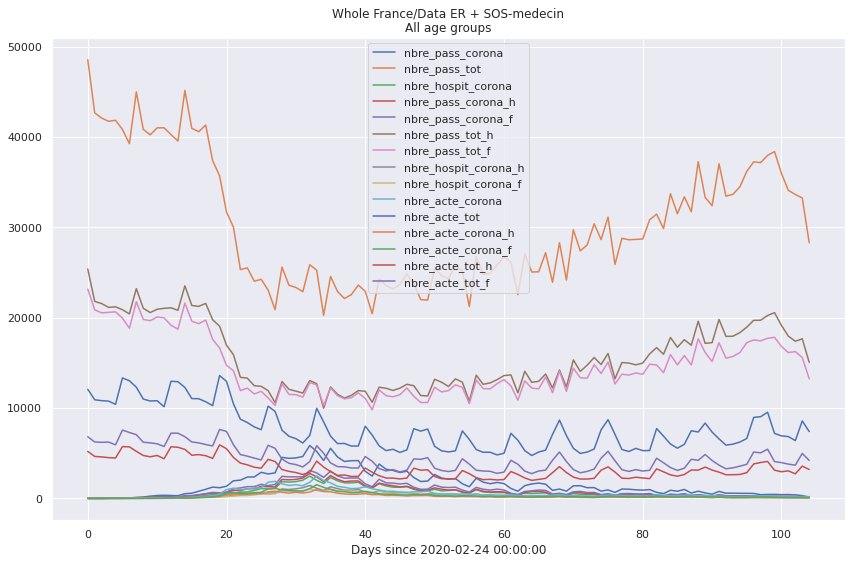

In [21]:
dfGr = PAN.DataFrame(gr_all_age_regions.copy(), columns=gr_all_age_regions.columns[1:])
painter = figureTSFromFrame(dfGr,figsize=(12,8))
painter.doPlot()
painter.setAttrs(label=f"Days since {painter.dt[0]}",
                 title="Whole France/Data ER + SOS-medecin\nAll age groups",
                 legend=True,
                 xlabel=f"Days since {painter.dt[0]}")
        
PAN.set_option('display.max_colwidth', None)
display(meta_QuotReg[[ "Colonne","Description_FR" ]])
ImgMgr.save_fig("FIG002")

Then, I look at the national data, as represented in `data_dailyFrance` and `data_daily`

In [22]:
print(f"data_daily: {data_daily.shape}")
print(f"{','.join(data_daily.columns)}")
display(data_daily.describe())
display(data_daily[:5])

print("data_dailyFrance:  {data_dailyFrance.shape}")
print(f"{','.join(data_dailyFrance.columns)}")
display(data_dailyFrance.describe())
display(data_dailyFrance[:5])

data_daily: (63630, 18)
dep,date_de_passage,sursaud_cl_age_corona,nbre_pass_corona,nbre_pass_tot,nbre_hospit_corona,nbre_pass_corona_h,nbre_pass_corona_f,nbre_pass_tot_h,nbre_pass_tot_f,nbre_hospit_corona_h,nbre_hospit_corona_f,nbre_acte_corona,nbre_acte_tot,nbre_acte_corona_h,nbre_acte_corona_f,nbre_acte_tot_h,nbre_acte_tot_f


,nbre_pass_corona,nbre_pass_tot,nbre_hospit_corona,nbre_pass_corona_h,nbre_pass_corona_f,nbre_pass_tot_h,nbre_pass_tot_f,nbre_hospit_corona_h,nbre_hospit_corona_f,nbre_acte_corona,nbre_acte_tot,nbre_acte_corona_h,nbre_acte_corona_f,nbre_acte_tot_h,nbre_acte_tot_f
count,62875.000000,62875.000000,62875.000000,10495.000000,10495.000000,10495.000000,10495.000000,10495.000000,10495.000000,28828.000000,28828.000000,4828.000000,4828.000000,4828.000000,4828.000000
mean,5.288557,101.078123,2.094282,7.291949,8.547308,157.062601,145.677180,3.351596,2.921201,3.887956,56.018593,4.936620,6.669014,71.315037,95.912593
std,16.675622,152.210659,6.229613,16.287006,17.840024,136.540248,124.974354,7.295752,5.620230,10.897916,92.556663,9.117544,12.379363,69.924885,92.312838
min,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000
25%,0.000000,25.000000,0.000000,0.000000,0.000000,66.000000,62.000000,0.000000,0.000000,0.000000,11.000000,0.000000,0.000000,30.000000,42.000000
50%,1.000000,50.000000,0.000000,3.000000,3.000000,114.000000,106.000000,1.000000,1.000000,1.000000,25.000000,2.000000,3.000000,50.000000,67.000000
75%,4.000000,110.000000,2.000000,7.000000,9.000000,203.000000,189.000000,4.000000,3.000000,3.000000,63.000000,5.000000,7.000000,83.000000,112.000000
max,635.000000,2240.000000,203.000000,320.000000,315.000000,1156.000000,1084.000000,130.000000,76.000000,259.000000,1444.000000,121.000000,144.000000,621.000000,824.000000


,dep,date_de_passage,sursaud_cl_age_corona,nbre_pass_corona,nbre_pass_tot,nbre_hospit_corona,nbre_pass_corona_h,nbre_pass_corona_f,nbre_pass_tot_h,nbre_pass_tot_f,nbre_hospit_corona_h,nbre_hospit_corona_f,nbre_acte_corona,nbre_acte_tot,nbre_acte_corona_h,nbre_acte_corona_f,nbre_acte_tot_h,nbre_acte_tot_f
0,01,2020-02-24,0,0.0,357.0,0.0,0.0,0.0,202.0,155.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN
1,01,2020-02-24,A,0.0,73.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,01,2020-02-24,B,0.0,155.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,01,2020-02-24,C,0.0,61.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,01,2020-02-24,D,0.0,28.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


data_dailyFrance:  {data_dailyFrance.shape}
fra,date_de_passage,sursaud_cl_age_corona,nbre_pass_corona,nbre_pass_tot,nbre_hospit_corona,nbre_pass_corona_h,nbre_pass_corona_f,nbre_pass_tot_h,nbre_pass_tot_f,nbre_hospit_corona_h,nbre_hospit_corona_f,nbre_acte_corona,nbre_acte_tot,nbre_acte_corona_h,nbre_acte_corona_f,nbre_acte_tot_h,nbre_acte_tot_f


,nbre_pass_corona,nbre_pass_tot,nbre_hospit_corona,nbre_pass_corona_h,nbre_pass_corona_f,nbre_pass_tot_h,nbre_pass_tot_f,nbre_hospit_corona_h,nbre_hospit_corona_f,nbre_acte_corona,nbre_acte_tot,nbre_acte_corona_h,nbre_acte_corona_f,nbre_acte_tot_h,nbre_acte_tot_f
count,615.000000,630.000000,604.000000,102.000000,104.000000,105.000000,105.000000,102.000000,100.000000,573.000000,630.000000,97.000000,97.000000,105.000000,105.000000
mean,540.679675,10087.757143,218.009934,750.284314,862.538462,15698.780952,14560.780952,344.852941,306.580000,195.605585,2563.339683,245.711340,331.938144,3279.133333,4410.152381
std,830.044300,9896.660097,342.218055,643.713613,764.417729,3717.274043,3260.130793,328.168648,263.622939,317.379152,2711.280660,208.796799,309.659787,1055.053162,1330.503706
min,1.000000,1878.000000,1.000000,11.000000,1.000000,9969.000000,9798.000000,1.000000,3.000000,1.000000,365.000000,2.000000,4.000000,1990.000000,2735.000000
25%,74.000000,3851.750000,25.750000,282.000000,287.250000,12464.000000,11915.000000,105.250000,97.750000,29.000000,802.750000,115.000000,138.000000,2420.000000,3273.000000
50%,231.000000,5946.000000,91.500000,534.500000,565.500000,14802.000000,13722.000000,215.000000,202.500000,72.000000,1323.000000,149.000000,196.000000,2970.000000,4104.000000
75%,638.500000,9940.000000,265.750000,1052.750000,1236.750000,19034.000000,16797.000000,472.250000,451.250000,205.000000,3138.000000,323.000000,462.000000,3970.000000,5211.000000
max,5851.000000,48476.000000,2463.000000,2759.000000,3092.000000,25342.000000,23129.000000,1424.000000,1039.000000,2485.000000,13594.000000,965.000000,1516.000000,5920.000000,7627.000000


,fra,date_de_passage,sursaud_cl_age_corona,nbre_pass_corona,nbre_pass_tot,nbre_hospit_corona,nbre_pass_corona_h,nbre_pass_corona_f,nbre_pass_tot_h,nbre_pass_tot_f,nbre_hospit_corona_h,nbre_hospit_corona_f,nbre_acte_corona,nbre_acte_tot,nbre_acte_corona_h,nbre_acte_corona_f,nbre_acte_tot_h,nbre_acte_tot_f
0,FR,2020-02-24,0,1.0,48476.0,NaN,NaN,1.0,25342.0,23129.0,NaN,NaN,NaN,12071.0,NaN,NaN,5195.0,6819.0
1,FR,2020-02-24,A,NaN,10458.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3330.0,NaN,NaN,NaN,NaN
2,FR,2020-02-24,B,1.0,17611.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5224.0,NaN,NaN,NaN,NaN
3,FR,2020-02-24,C,NaN,9402.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1948.0,NaN,NaN,NaN,NaN
4,FR,2020-02-24,D,NaN,4210.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,556.0,NaN,NaN,NaN,NaN


### Hospital data
DF: hospNouveau  File: donnees-hospitalieres-nouveaux-covid19

,Colonne,Description_EN
0,dep,Department
1,jour,Date of notice
2,incid_hosp,Daily number of newly hospitalized persons
3,incid_rea,Daily number of new intensive care admissions
4,incid_dc,Daily number of newly deceased persons
5,incid_rad,Daily number of new home returns


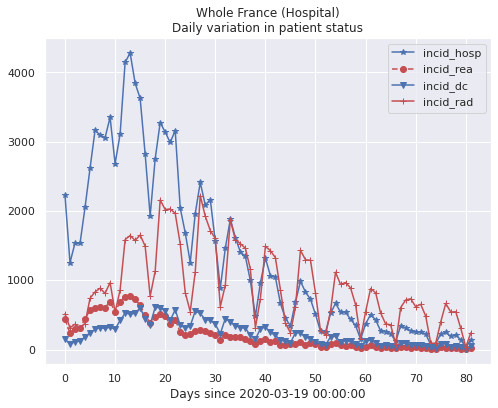

In [23]:
gr_all_data_hospNouveau=data_hospNouveau.groupby('jour').sum()
dfGrHN = PAN.DataFrame(gr_all_data_hospNouveau)
colOpts = {'incid_dc': {"c":"b","marker":"v"},  
           'incid_rea': {"c":"r","marker":"o", "linestyle":"--"},
           'incid_rad': {"marker":"+"},
           'incid_hosp': {"marker":"*"}
          }

painter = figureTSFromFrame(dfGrHN)
painter.doPlot()
painter.setAttrs(colOpts=colOpts,
                 xlabel=f"Days since {painter.dt[0]}", 
                 title="Whole France (Hospital)\nDaily variation in patient status",
                 legend=True  ) 

PAN.set_option('display.max_colwidth', None)
display(meta_HospIncid[[ "Colonne","Description_EN" ]])

,Colonne,Description_EN
0,dep,Department
1,sexe,Sex
2,jour,Date of notice
3,hosp,Number of people currently hospitalized
4,rea,Number of people currently in resuscitation or critical care
5,rad,Total amount of patient that returned home
6,dc,Total amout of deaths at the hospital


Saving figure FIG003


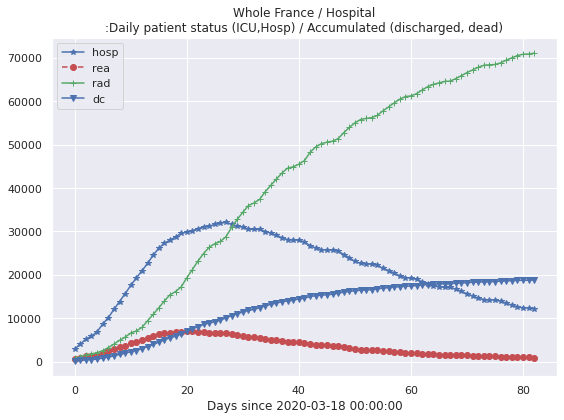

In [24]:
gr_all_data_hosp=data_hosp.loc[data_hosp["sexe"] == 0 ].groupby('jour').sum()
cols = [ c for c in gr_all_data_hosp.columns if c != 'sexe']
dfGrH = PAN.DataFrame(gr_all_data_hosp[cols])
colOpts = { 'dc': {"c":"b","marker":"v"},  
           'rea': {"c":"r","marker":"o", "linestyle":"--"},
           'rad': {"marker":"+"},
           'hosp': {"marker":"*"}
          }
painter = figureTSFromFrame(dfGrH)
painter.doPlot()
painter.setAttrs( colOpts=colOpts,
                  xlabel=f"Days since {painter.dt[0]}",
                  title="Whole France / Hospital\n:Daily patient status (ICU,Hosp) / Accumulated (discharged, dead)",
                 legend=True) 
display(meta_Hosp[[ "Colonne","Description_EN" ]])
ImgMgr.save_fig("FIG003")

### Now analyze hospital data according to sex

In [25]:
data_hosp_DepSex=data_hosp.set_index(["dep","sexe"])
data_hosp_DepSex[data_hosp_DepSex.index.get_level_values(1)!=0]

d1 = data_hosp_DepSex[data_hosp_DepSex.index.get_level_values(1)==1]
d2 = data_hosp_DepSex[data_hosp_DepSex.index.get_level_values(1)==2]

d1s=d1.groupby("jour").sum()
d2s=d2.groupby("jour").sum()

dm= PAN.concat([d1s,d2s], axis=1)
cols1 = list(map (lambda x: x+"_M", d1s.columns))
cols2 = list(map (lambda x: x+"_F", d2s.columns))
dm.columns = (*cols1,*cols2)

(<class 'str'>)hosp_M not in {'dc_F': {'c': 'r', 'marker': 'v'}, 'dc_M': {'c': 'b', 'marker': 'v'}, 'rea_F': {'c': 'r', 'marker': 'o', 'linestyle': '--'}, 'rea_M': {'c': 'b', 'marker': 'o', 'linestyle': '--'}, 'rad_F': {'marker': '+'}, 'rad_M': {'marker': '+'}}
(<class 'str'>)hosp_F not in {'dc_F': {'c': 'r', 'marker': 'v'}, 'dc_M': {'c': 'b', 'marker': 'v'}, 'rea_F': {'c': 'r', 'marker': 'o', 'linestyle': '--'}, 'rea_M': {'c': 'b', 'marker': 'o', 'linestyle': '--'}, 'rad_F': {'marker': '+'}, 'rad_M': {'marker': '+'}}


,Colonne,Description_EN
0,dep,Department
1,sexe,Sex
2,jour,Date of notice
3,hosp,Number of people currently hospitalized
4,rea,Number of people currently in resuscitation or critical care
5,rad,Total amount of patient that returned home
6,dc,Total amout of deaths at the hospital


Saving figure FIG004


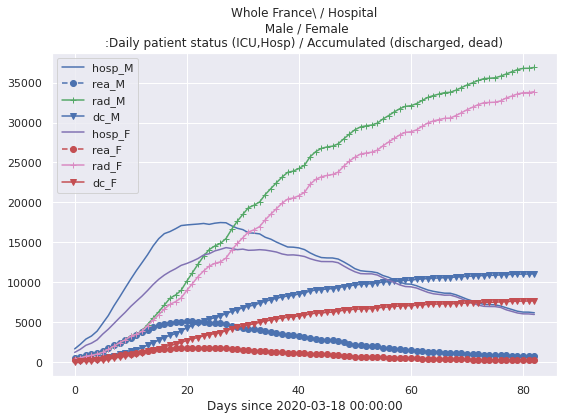

In [26]:
painter = figureTSFromFrame(dm)
colOpts = {'dc_F': {"c":"r","marker":"v"},  
           'dc_M': {"c":"b","marker":"v"},
           'rea_F': {"c":"r","marker":"o", "linestyle":"--"},  
           'rea_M': {"c":"b","marker":"o", "linestyle":"--"},
           'rad_F': {"marker":"+"},
           'rad_M': {"marker":"+"}
          }
painter.doPlotBycol()
painter.setAttrs(colOpts = colOpts,
                    xlabel  = f"Days since {painter.dt[0]}",
               title="Whole France\ / Hospital\n Male / Female\n:Daily patient status (ICU,Hosp) / Accumulated (discharged, dead)",
               legend=True    ) 
display(meta_Hosp[[ "Colonne","Description_EN" ]])
ImgMgr.save_fig("FIG004")

### Now analyze hospital data according to age
For now the data available in table `data_hospAge` covers a small number of days.... hopefully this may improve, either by more earlier data becoming available, or just by more data being collected day after day!

In [27]:
data_hosp_RegAge=data_hospAge.set_index(["reg","jour",'cl_age90'])
dhRA = data_hosp_RegAge[ data_hosp_RegAge.index.get_level_values(2)!=0 ].unstack('cl_age90')
dhRAg = dhRA.groupby("jour").sum()

ageClasses = sorted(set(dhRAg.columns.get_level_values(1)))
print(f"age classes = {ageClasses}")

levCat = sorted(set(dhRA.columns.get_level_values(0)))
levAge = sorted(set(dhRA.columns.get_level_values(1)))
subnodeSpec=(lambda i,j:{"nrows":i,"ncols":j})(*subPlotShape(len(levAge),maxCol=6))

print(f"nb age classes:{len(levAge)}\tsubnodeSpec:{subnodeSpec}")
if len(levAge) != len(ageClasses):
    raise RuntimeError("Inconsistent values for number of age classes")

age classes = [9, 19, 29, 39, 49, 59, 69, 79, 89, 90]
nb age classes:10	subnodeSpec:{'nrows': 3, 'ncols': 4}


In [28]:
colOpts = {'dc':  {"c":"b","marker":"v"},  
           'rea': {"c":"r","marker":"o", "linestyle":"--"},  
           'rad':  {"marker":"^"},
           'hosp': {"marker":"+"}
          }

,Colonne,Description_EN
0,dep,Department
1,sexe,Sex
2,jour,Date of notice
3,hosp,Number of people currently hospitalized
4,rea,Number of people currently in resuscitation or critical care
5,rad,Total amount of patient that returned home
6,dc,Total amout of deaths at the hospital


Saving figure FIG005


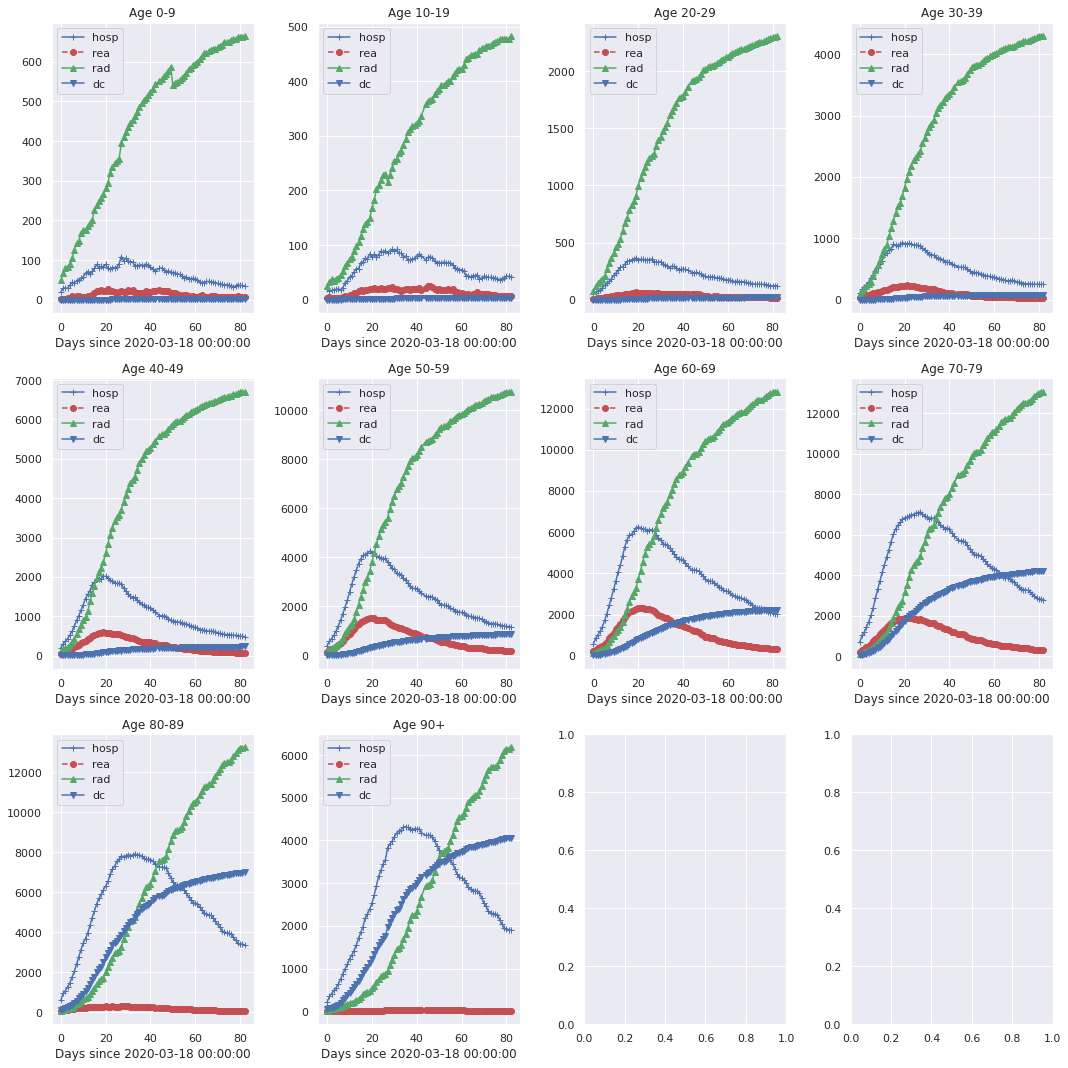

In [29]:
painter = figureTSFromFrame(None, subplots=subnodeSpec, figsize=(15,15))
for i in range(len(levAge)):
    cat = ageClasses[i]
    if cat < 90:
        title = f"Age {cat-9}-{cat}"
    else: 
        title = "Age 90+"
        
    dfExtract = dhRAg.loc(axis=1)[:,cat]
    # remove the now redundant information labeled 'cl_age90'
    dfExtract.columns = dfExtract.columns.levels[0]
    painter.doPlotBycol(dfExtract);
    painter.setAttrs(colOpts = colOpts,
                     xlabel  = f"Days since {painter.dt[0]}",
                     title   = title,
                     legend  = True    ) 
    
    
    painter.advancePlotIndex()

display(meta_Hosp[[ "Colonne","Description_EN" ]])
ImgMgr.save_fig("FIG005")

## Testing : Laboratory data

This concerns testing (I have not found the meta data yet, but column labels are clear enough).
The `data_dailyLab` data is split between age classes and departements.

In [30]:
todayStr = datetime.date.today().isoformat()    # handle a data error that appeared on 5/5/2020

Saving figure FIG006


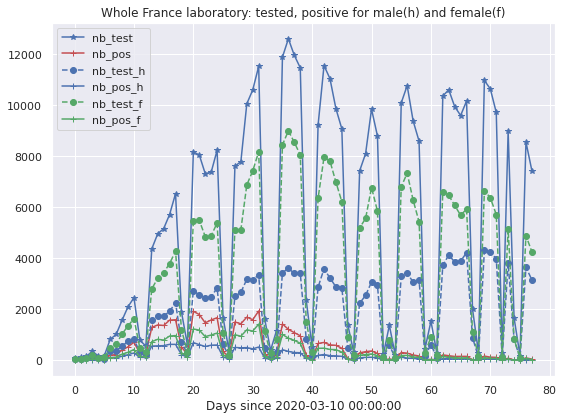

In [31]:
msk=d=data_dailyLab.loc[:,"jour"]<=todayStr      #there is an error in the version of the data distrib 05/05/2020
dl=data_dailyLab.loc[msk,:]
dlGr = dl.loc[dl["clage_covid"]=="0"].groupby('jour').sum()

painter = figureTSFromFrame(dlGr)
colOpts = {'nb_test': {"c":"b", "marker":"*"},  
           'nb_pos':  {"c":"r", "marker":"+"},
           'nb_test_h': {"c":"b","marker":"o", "linestyle":"--"},  
           'nb_test_f': {"c":"g","marker":"o", "linestyle":"--"},
           'nb_pos_h': {"c":"b", "marker":"+"},
           'nb_pos_f': {"c":"g", "marker":"+"}
          }
painter.doPlotBycol()
painter.setAttrs(colOpts = colOpts,
                    xlabel  = f"Days since {painter.dt[0]}",
               title="Whole France laboratory: tested, positive for male(h) and female(f)",
               legend=True    ) 

ImgMgr.save_fig("FIG006")

In [32]:
dlGr.describe()

,nb_test,nb_pos,nb_test_h,nb_pos_h,nb_test_f,nb_pos_f
count,78.000000,78.000000,78.000000,78.000000,78.000000,78.000000
mean,5427.307692,514.000000,1857.064103,179.910256,3563.051282,333.910256
std,4397.888718,598.726332,1484.655545,206.974444,2957.383364,397.288151
min,79.000000,1.000000,38.000000,1.000000,41.000000,0.000000
25%,792.000000,62.250000,315.750000,24.000000,470.500000,36.250000
50%,6124.500000,225.500000,2079.000000,88.000000,4022.500000,134.500000
75%,9690.500000,703.000000,3170.750000,269.750000,6183.250000,471.500000
max,12608.000000,1932.000000,4304.000000,691.000000,8997.000000,1415.000000


Analyze laboratory data according to age

In [33]:
data_dailyLab.columns
dataDLab = data_dailyLab.loc[msk,:].copy()

In [34]:
dataDLab=dataDLab.set_index(["dep","jour",'clage_covid'])
dhRA = dataDLab[ dataDLab.index.get_level_values(2)!='0' ].unstack('clage_covid')
dhRAg = dhRA.groupby("jour").sum()

In [35]:
ageClasses = sorted(set(dhRAg.columns.get_level_values(1)))
print(f"age classes = {ageClasses}")

levCat = sorted(set(dhRA.columns.get_level_values(0)))
levAge = sorted(set(dhRA.columns.get_level_values(1)))
subnodeSpec=(lambda i,j:{"nrows":i,"ncols":j})(*subPlotShape(len(levAge),maxCol=6))

print(f"nb age classes:{len(levAge)}\tsubnodeSpec:{subnodeSpec}")
if len(levAge) != len(ageClasses):
    raise RuntimeError("Inconsistent values for number of age classes")

age classes = ['A', 'B', 'C', 'D', 'E']
nb age classes:5	subnodeSpec:{'nrows': 2, 'ncols': 3}


In [36]:
colOpts = {'nb_test': {"c":"b", "marker":"*"},  
           'nb_pos':  {"c":"r", "marker":"+"},
           'nb_test_h': {"c":"b","marker":"o", "linestyle":"--"},  
           'nb_test_f': {"c":"g","marker":"o", "linestyle":"--"},
           'nb_pos_h': {"c":"b", "marker":"+"},
           'nb_pos_f': {"c":"g", "marker":"+"}
          }

,Code tranches d'age,Unnamed: 1
0,0,tous âges
1,A,moins de 15 ans
2,B,15-44 ans
3,C,45-64 ans
4,D,65-74 ans
5,E,75 et plus


Saving figure FIG007


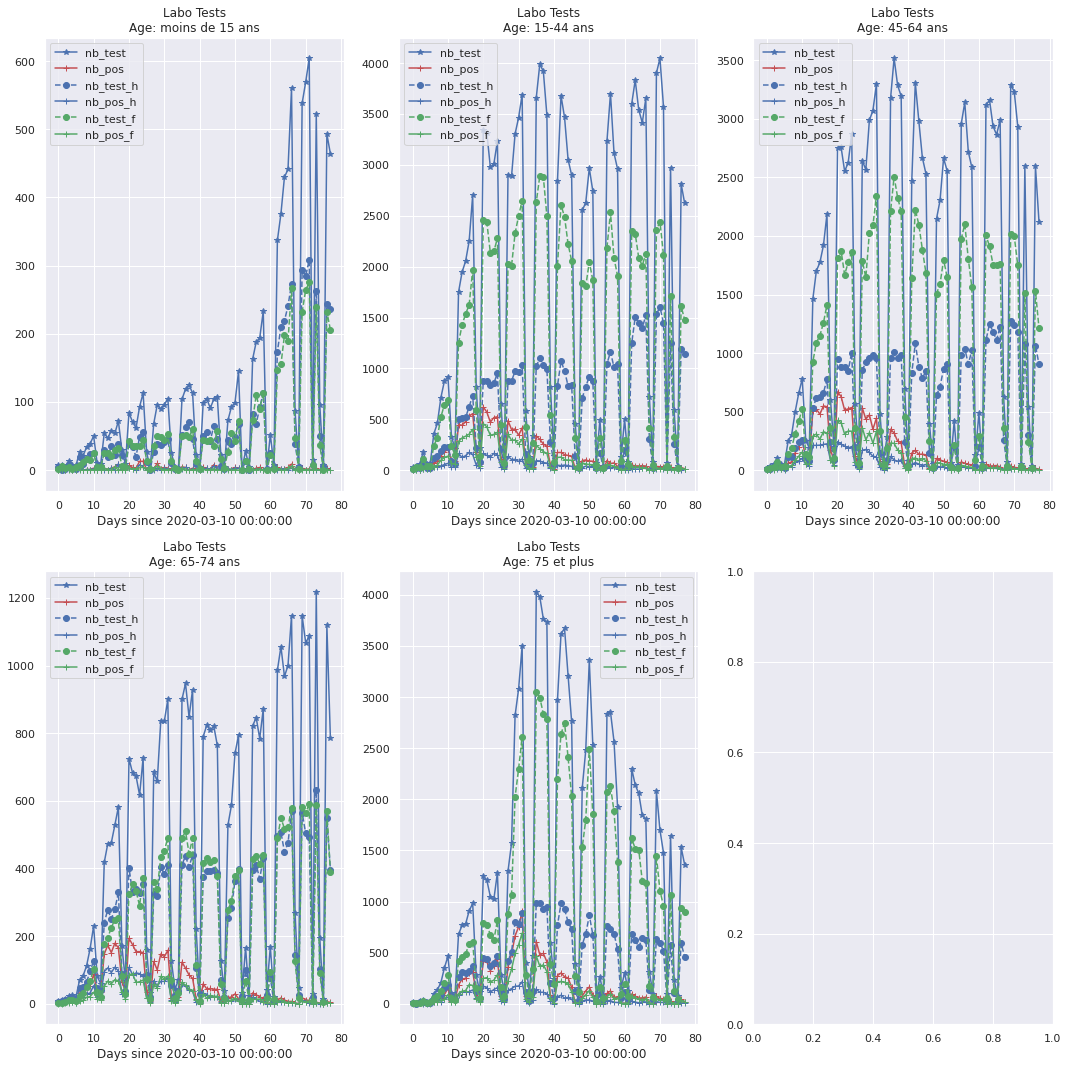

In [37]:
painter = figureTSFromFrame(None, subplots=subnodeSpec, figsize=(15,15))
for i in 'ABCDE':
    cat = meta_Ages.loc[meta_Ages.iloc[:,0]==i].iloc[:,1].values[0]
    title = f"Labo Tests\nAge: {cat}"

    dfExtract = dhRAg.loc(axis=1)[:,i]
    # remove the now redundant information labeled 'cl_age90'
    dfExtract.columns = dfExtract.columns.levels[0]
    painter.doPlotBycol(dfExtract);
    
    painter.setAttrs(colOpts = colOpts,
                     xlabel  = f"Days since {painter.dt[0]}",
                     title   = title,
                     legend  = True    ) 
    
    
    painter.advancePlotIndex()

display(meta_Ages)
ImgMgr.save_fig("FIG007")

# Merge COVID and demographics data
See the `Pop-Data-FromGouv.ipynb` notebook for more details on the demographics data obtained from
INSEE (https://www.insee.fr/fr/accueil). 

Prepare the data for a database style join/merge, documented on https://pandas.pydata.org/pandas-docs/stable/user_guide/merging.html.
First we need to establish "dep" as an index in hospital data: 

In [38]:
hndDf = data_hospNouveau.copy()
hndDf.set_index("dep");

Then we extract the demographic information and set index "dep" 

In [39]:
depStats = inseeDep.iloc[:,[2,3,7,8]].copy()
cols = depStats.columns.values
cols[0]="dep"
depStats.columns = cols
depStats.set_index("dep");

Now we perform the merge, and group by date and 'départements': 

In [40]:
hndMerged = PAN.merge(hndDf,depStats, on="dep" ) 
hndGrMerged=hndMerged.groupby(["jour","dep"]).sum()

For now, look at daily statistics normalized by concerned population (unit= event per million people)

In [41]:
hndGMJour = hndGrMerged.groupby("jour").sum()
colLabs = ("incid_hosp", "incid_rea", "incid_dc", "incid_rad")
for lab in colLabs:
    hndGMJour[lab+"_rate"] = hndGMJour[lab]/hndGMJour["Population totale"]*1.0e6

And the graph can be readily generated:

,Colonne,Description_EN
0,dep,Department
1,jour,Date of notice
2,incid_hosp,Daily number of newly hospitalized persons
3,incid_rea,Daily number of new intensive care admissions
4,incid_dc,Daily number of newly deceased persons
5,incid_rad,Daily number of new home returns


Saving figure FIG008


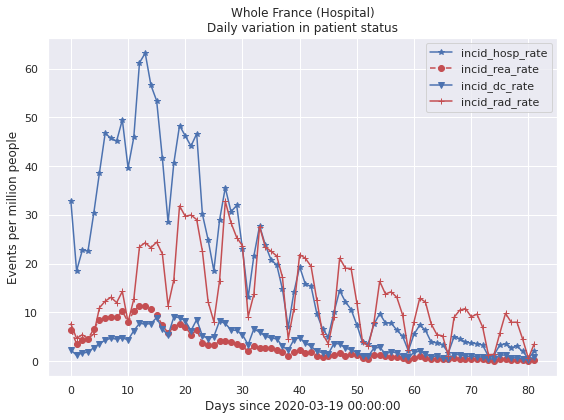

In [42]:
ncolLabs = list ( x+"_rate" for x in colLabs)
df=hndGMJour.loc[:,ncolLabs]
colOpts = {'incid_dc_rate'  : {"c":"b","marker":"v"},  
           'incid_rea_rate' : {"c":"r","marker":"o", "linestyle":"--"},
           'incid_rad_rate' : {"marker":"+"},
           'incid_hosp_rate': {"marker":"*"}
          }

painter = figureTSFromFrame(df)
painter.doPlot()
painter.setAttrs(colOpts=colOpts,
                 xlabel=f"Days since {painter.dt[0]}", 
                 ylabel="Events per million people",
                 title="Whole France (Hospital)\nDaily variation in patient status",
                 legend=True  ) 

PAN.set_option('display.max_colwidth', None)
display(meta_HospIncid[[ "Colonne","Description_EN" ]])
ImgMgr.save_fig("FIG008")

Now we can do the same exercise keeping the 'département' information around:

In [43]:
hndGMDepJour = hndGrMerged.iloc[:,[0,1,2,3,5]].copy()

In [44]:
colLabs = ("incid_hosp", "incid_rea", "incid_dc", "incid_rad")
for lab in colLabs:
    hndGMDepJour[lab+"_rate"] = hndGMDepJour[lab]/hndGMDepJour["Population totale"]*1.0e6

In [45]:
hGMDJExtract = hndGMDepJour.iloc[:,range(5,9)]

### Look at the distribution accross areas ('departements')


This is simply an effort to get 'departement's by name rather than by number (you were supposed to learn the mapping in school... that was a long time ago... )

In [46]:
inseeDepLib=inseeDep.iloc[:,[2,3]]
cl=list(inseeDepLib.columns)
cl[0]="dep"
inseeDepLib.columns=cl

In [47]:
colLabs = ("incid_hosp", "incid_rea", "incid_dc", "incid_rad")
for lab in colLabs:
    hndMerged[lab+"_rate"] = hndMerged[lab]/hndMerged["Population totale"]*1.0e6    

Here we show the heat map for the most active days in the various 'départements', where activity is measured in events per million population.

Saving figure FIG016
Saving figure FIG017
Saving figure FIG018
Saving figure FIG019


<Figure size 1296x1296 with 0 Axes>

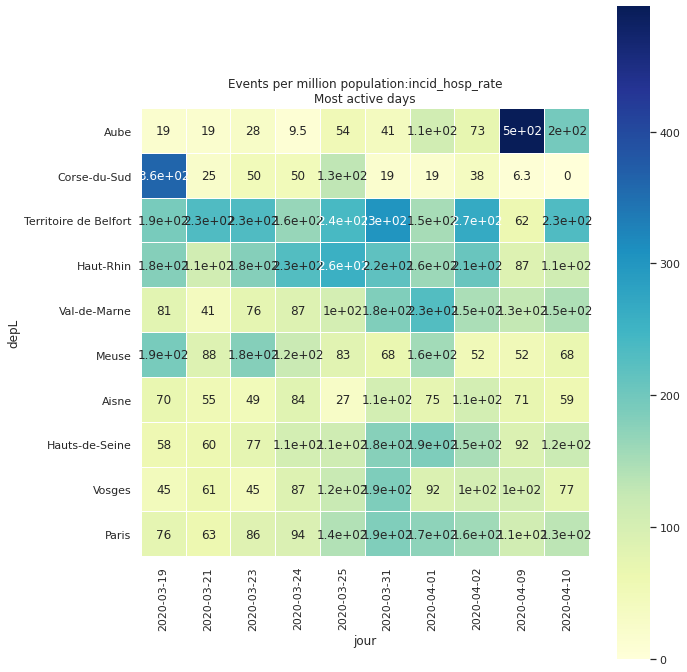

<Figure size 1296x1296 with 0 Axes>

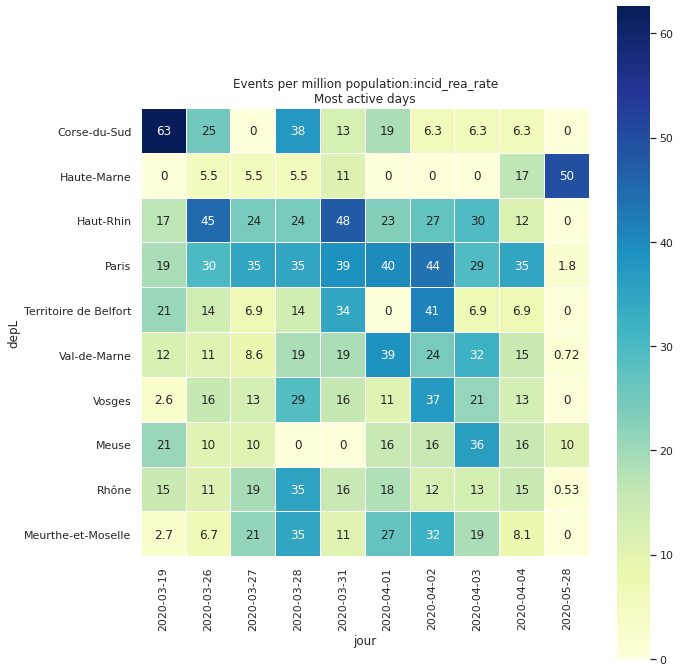

<Figure size 1296x1296 with 0 Axes>

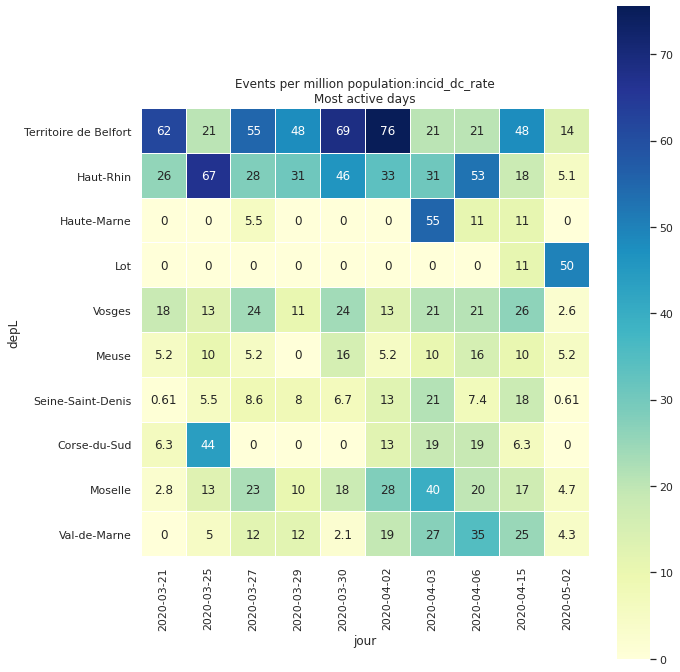

<Figure size 1296x1296 with 0 Axes>

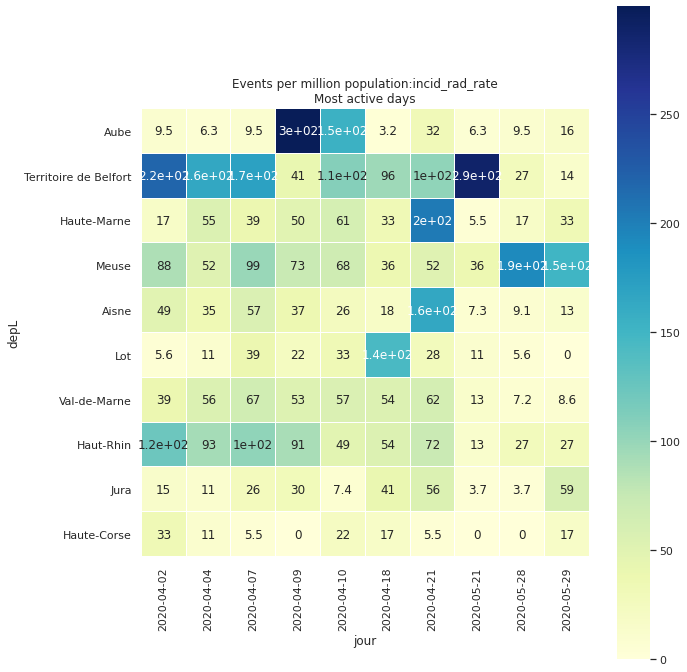

In [48]:
cols=list(hndMerged.columns)
cols[6]="depL"
hndMerged.columns=cols
i=15
rowsSel={}
for icase in range(9,13):
  i+=1
  hhn=hndMerged.iloc[:,[6,1,icase]]
    
  lwhat = hndMerged.columns[icase]
  hh = hhn.pivot(index="depL", columns='jour',values=lwhat)
    
  largeRows=hh.max(axis=1).nlargest(10)
  smallRows=hh.max(axis=1).nsmallest(10)
  largeCols=hh.max(axis=0).nlargest(10)
  smallCols=hh.max(axis=0).nsmallest(10)
    
  rowsSel[lwhat] = (icase,largeRows.index,largeCols.index)  
  hzz=hh.loc[largeRows.index,sorted(largeCols.index)]
  hmax  = hzz.max().max()
  hmin  = hzz.min().min()

  PLT.figure(figsize=(18,18))
  DCTE.simpleHeatMap(data=hzz, 
                     title="Events per million population:"+lwhat+"\nMost active days", 
                     SNSArgs={'vmax':hmax, 'vmin':hmin
                             })
  #
  ImgMgr.save_fig(f"FIG{i:03}")

Saving figure FIG021
Saving figure FIG022
Saving figure FIG023
Saving figure FIG024


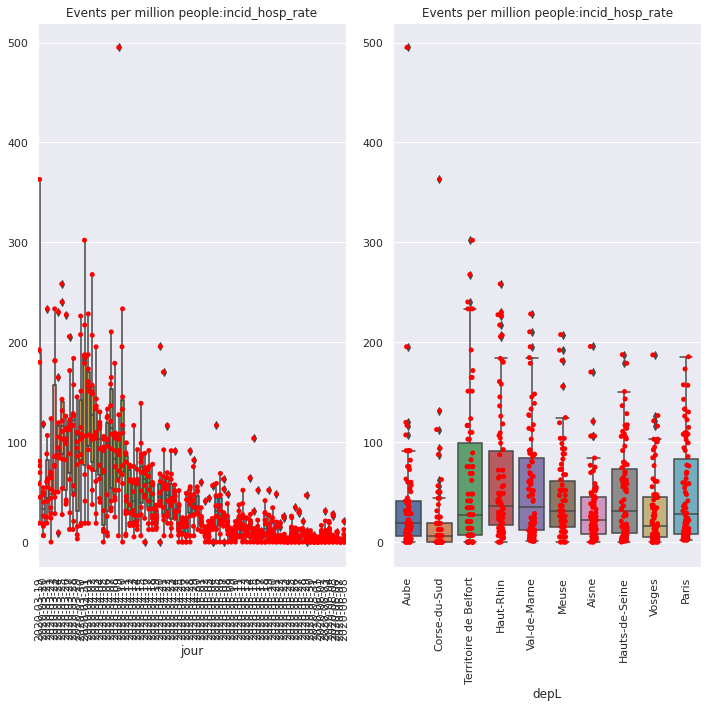

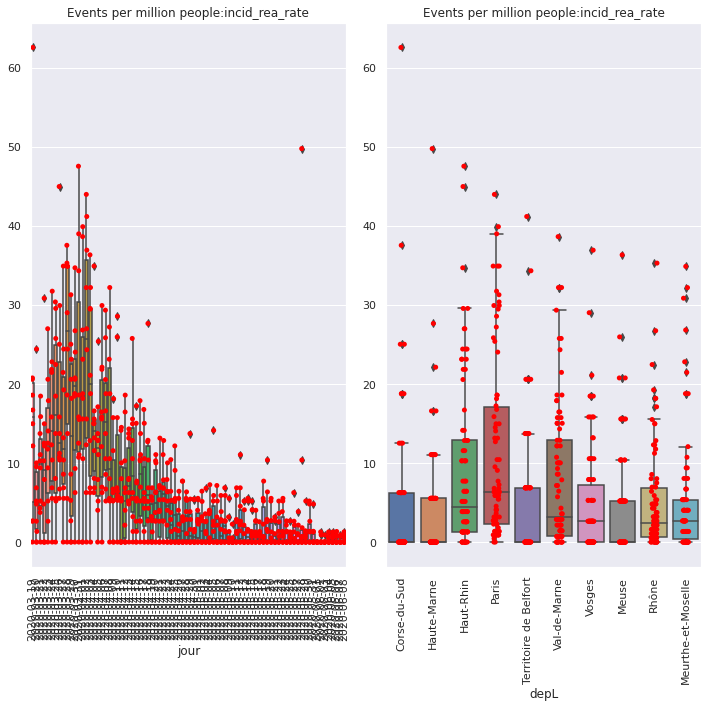

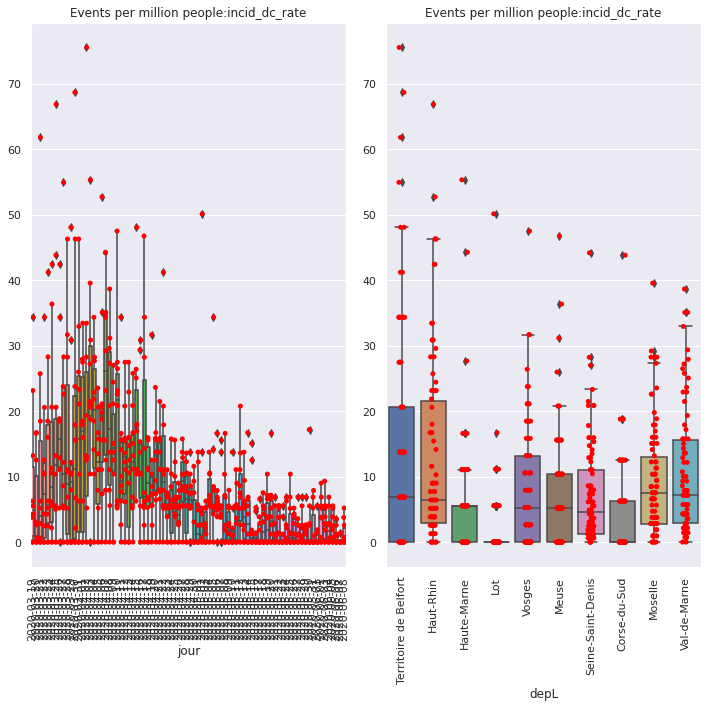

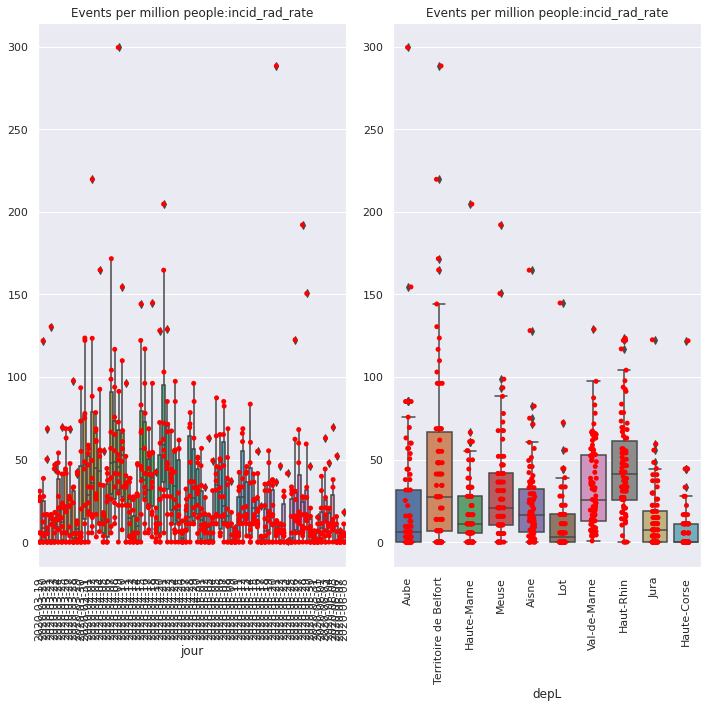

In [49]:
i = 0
snsDtl={"SNSBox+":{"xtickLabels":{"rotation":90}},
        "SNSStrip+":{"xtickLabels":{"rotation":90}}}
for lwhat in rowsSel:  
  i+=1
  icase = rowsSel[lwhat][0]
  hhn=hndMerged.iloc[:,[6,1,icase]]
    
  lwhat = hndMerged.columns[icase]
  hh = hhn.pivot(index="depL", columns='jour',values=lwhat)
    
  largeRows=rowsSel[lwhat][1]
  largeCols=rowsSel[lwhat][2]
    
  hzz=hh.loc[largeRows, : ]
  hmax  = hzz.max().max()
  hmin  = hzz.min().min()

  PLT.figure(figsize=(10,10)) 
  PLT.title("Event per million people:"+lwhat)
  title = "Events per million people:"+lwhat
  PLT.subplot(1,2,1)
  DCTE.boxStripPlot( data = hzz, x=None, y=None, title=title, **snsDtl)
  PLT.subplot(1,2,2)
  DCTE.boxStripPlot( data = hzz.transpose(), x=None, y=None, title=title, **snsDtl)
    
  ImgMgr.save_fig(f"FIG{(i+20):03}")  

### Another look at departmental data

In [50]:
hndMerged.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8200 entries, 0 to 8199
Data columns (total 13 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   dep                    8200 non-null   object 
 1   jour                   8200 non-null   object 
 2   incid_hosp             8200 non-null   int64  
 3   incid_rea              8200 non-null   int64  
 4   incid_dc               8200 non-null   int64  
 5   incid_rad              8200 non-null   int64  
 6   depL                   8200 non-null   object 
 7   Population municipale  8200 non-null   int64  
 8   Population totale      8200 non-null   int64  
 9   incid_hosp_rate        8200 non-null   float64
 10  incid_rea_rate         8200 non-null   float64
 11  incid_dc_rate          8200 non-null   float64
 12  incid_rad_rate         8200 non-null   float64
dtypes: float64(4), int64(6), object(3)
memory usage: 896.9+ KB


In [51]:
hndMerged.iloc[:4,:]

,dep,jour,incid_hosp,incid_rea,incid_dc,incid_rad,depL,Population municipale,Population totale,incid_hosp_rate,incid_rea_rate,incid_dc_rate,incid_rad_rate
0,01,2020-03-19,1,0,0,0,Ain,643350,659180,1.517036,0.000000,0.0,0.000000
1,01,2020-03-20,0,0,0,1,Ain,643350,659180,0.000000,0.000000,0.0,1.517036
2,01,2020-03-21,4,0,0,0,Ain,643350,659180,6.068145,0.000000,0.0,0.000000
3,01,2020-03-22,3,1,0,1,Ain,643350,659180,4.551109,1.517036,0.0,1.517036


In [52]:
hndMerged["date"] = PAN.to_datetime(hndMerged.loc[:,"jour"], format="%Y/%m/%d")
dateStart = hndMerged["date"].min()
dateEnd   = hndMerged["date"].max() 
dateSpan  = dateEnd - dateStart 
print(f"Our statistics span {dateSpan.days+1} days, start: {dateStart} and end {dateEnd}")

hndMerged["elapsedDays"] = (hndMerged["date"] - dateStart).dt.days

Our statistics span 82 days, start: 2020-03-19 00:00:00 and end 2020-06-08 00:00:00


In [53]:
dtx = hndMerged[ hndMerged["Population totale"] > 1.0e6 ]
dtg = dtx.groupby("dep")
subnodeSpec=(lambda i,j:{"nrows":i,"ncols":j})(*subPlotShape(len(dtg),maxCol=4, colFirst=False))

Departement=Alpes-Maritimes, pop:1.097496M
Departement=Bouches-du-Rhône, pop:2.048504M
Departement=Haute-Garonne, pop:1.385122M
Departement=Gironde, pop:1.607545M
Departement=Hérault, pop:1.162867M
Departement=Ille-et-Vilaine, pop:1.084554M
Departement=Isère, pop:1.283384M
Departement=Loire-Atlantique, pop:1.423152M
Departement=Moselle, pop:1.062217M
Departement=Nord, pop:2.635255M
Departement=Pas-de-Calais, pop:1.489983M
Departement=Bas-Rhin, pop:1.141511M
Departement=Rhône, pop:1.869599M
Departement=Paris, pop:2.204773M
Departement=Seine-Maritime, pop:1.275559M
Departement=Seine-et-Marne, pop:1.420469M
Departement=Yvelines, pop:1.463091M
Departement=Var, pop:1.075653M
Departement=Essonne, pop:1.310599M
Departement=Hauts-de-Seine, pop:1.625917M
Departement=Seine-Saint-Denis, pop:1.630133M
Departement=Val-de-Marne, pop:1.397035M
Departement=Val-d'Oise, pop:1.239262M
Saving figure FIG050


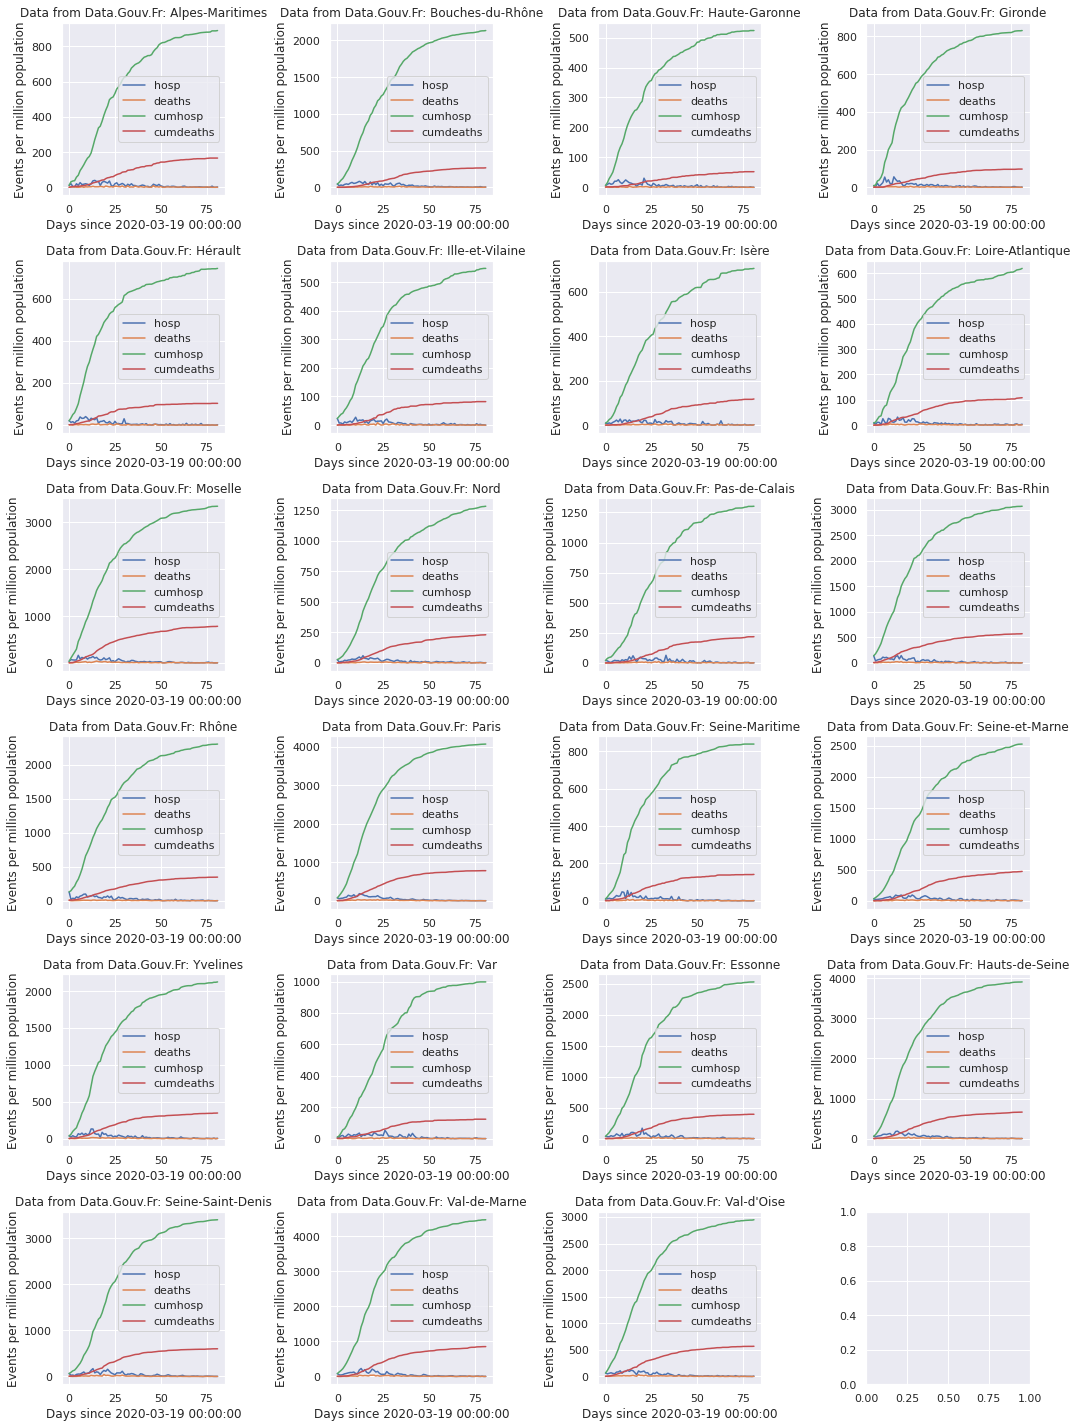

In [54]:
painter = figureFromFrame(None, subplots=subnodeSpec, figsize=(15,20))
for (departement,dfExtractOrig) in dtg :
    pop = dfExtractOrig["Population totale"].iloc[0]
    depL = dfExtractOrig["depL"].iloc[0]
    print(f"Departement={depL}, pop:{pop/1.0E6}M")
    dfExtract = dfExtractOrig.set_index("elapsedDays").copy()
    dfExtract.loc[:,"cumhosp"] = dfExtract.loc[:,"incid_hosp"].sort_index().cumsum()/dfExtract.loc[:,"Population totale"]*1.0E6
    dfExtract.loc[:,"cumdeaths"] = dfExtract.loc[:,"incid_dc"].sort_index().cumsum()/dfExtract.loc[:,"Population totale"]*1.0E6
    dfExtract.loc[:,"hosp"] = dfExtract.loc[:,"incid_hosp"]/dfExtract.loc[:,"Population totale"]*1.0E6
    dfExtract.loc[:,"deaths"] = dfExtract.loc[:,"incid_dc"]/dfExtract.loc[:,"Population totale"]*1.0E6
    painter.doPlot(df = dfExtract.loc[:,["hosp","deaths","cumhosp","cumdeaths"]])
    painter.setAttrs(label=f"Days since {dateStart}",
                 title=f"Data from Data.Gouv.Fr: {depL}",
                 legend=True,
                 xlabel=f"Days since {dateStart}",
                 ylabel="Events per million population"   )
        
    painter.advancePlotIndex()  
ImgMgr.save_fig("FIG050")  

Departement=Alpes-Maritimes, pop:1.097496M
Departement=Bouches-du-Rhône, pop:2.048504M
Departement=Haute-Garonne, pop:1.385122M
Departement=Gironde, pop:1.607545M
Departement=Hérault, pop:1.162867M
Departement=Ille-et-Vilaine, pop:1.084554M
Departement=Isère, pop:1.283384M
Departement=Loire-Atlantique, pop:1.423152M
Departement=Moselle, pop:1.062217M
Departement=Nord, pop:2.635255M
Departement=Pas-de-Calais, pop:1.489983M
Departement=Bas-Rhin, pop:1.141511M
Departement=Rhône, pop:1.869599M
Departement=Paris, pop:2.204773M
Departement=Seine-Maritime, pop:1.275559M
Departement=Seine-et-Marne, pop:1.420469M
Departement=Yvelines, pop:1.463091M
Departement=Var, pop:1.075653M
Departement=Essonne, pop:1.310599M
Departement=Hauts-de-Seine, pop:1.625917M
Departement=Seine-Saint-Denis, pop:1.630133M
Departement=Val-de-Marne, pop:1.397035M
Departement=Val-d'Oise, pop:1.239262M
Saving figure FIG051


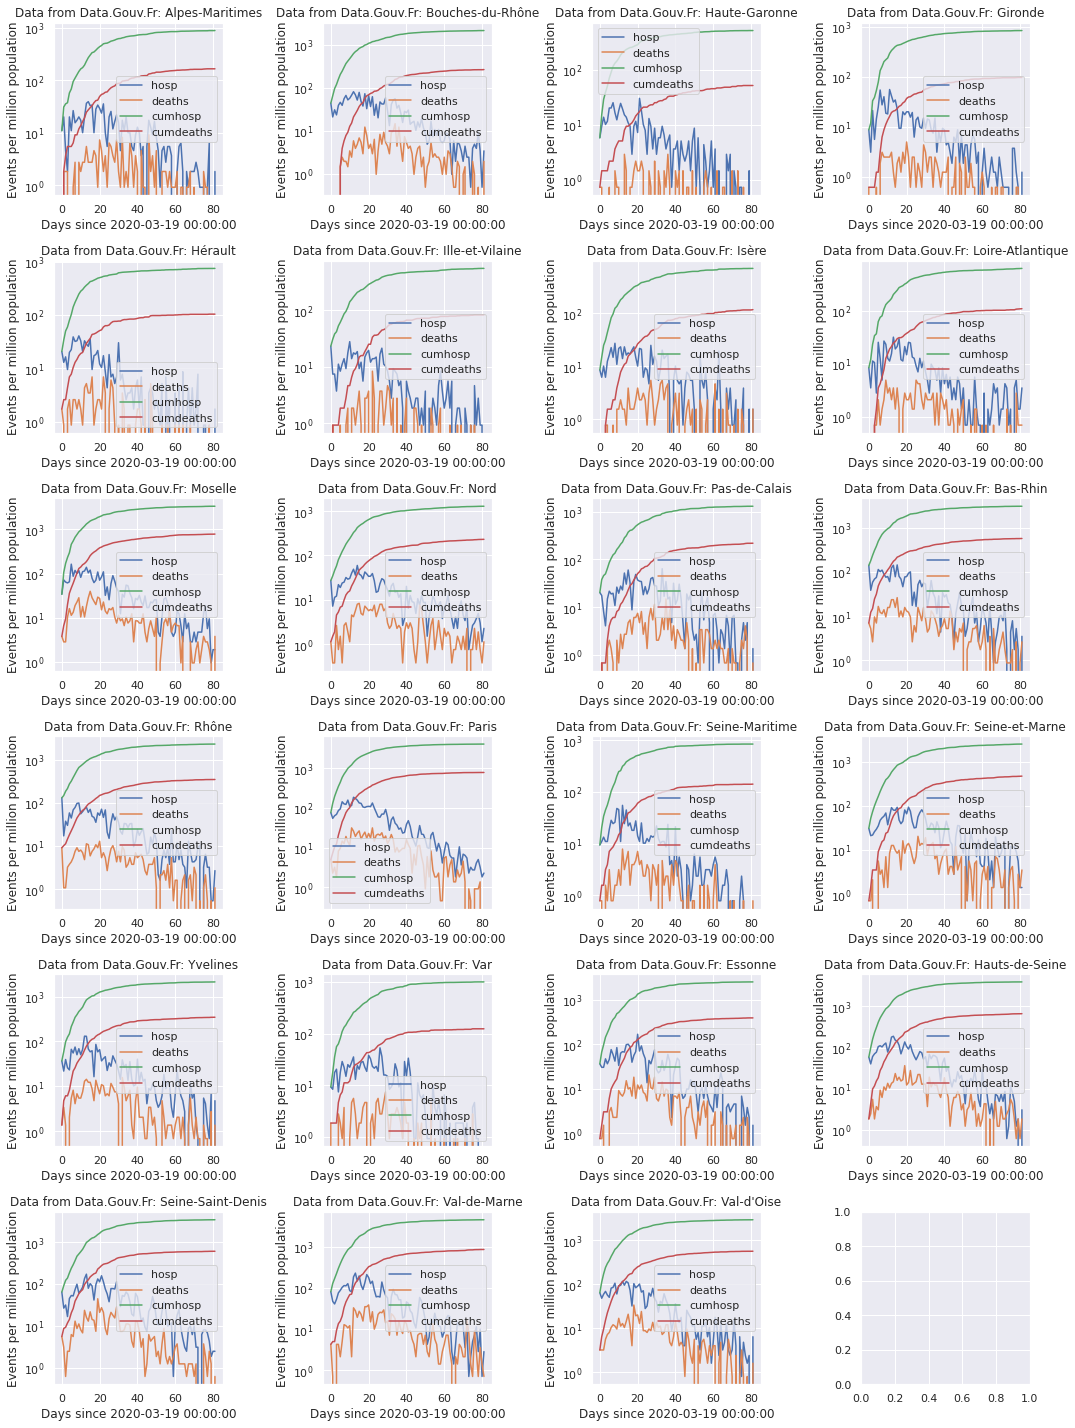

In [55]:
painter = figureFromFrame(None, subplots=subnodeSpec, figsize=(15,20))
for (departement,dfExtractOrig) in dtg :
    pop = dfExtractOrig["Population totale"].iloc[0]
    depL = dfExtractOrig["depL"].iloc[0]
    print(f"Departement={depL}, pop:{pop/1.0E6}M")
    dfExtract = dfExtractOrig.set_index("elapsedDays").copy()
    dfExtract.loc[:,"cumhosp"] = dfExtract.loc[:,"incid_hosp"].sort_index().cumsum()/dfExtract.loc[:,"Population totale"]*1.0E6
    dfExtract.loc[:,"cumdeaths"] = dfExtract.loc[:,"incid_dc"].sort_index().cumsum()/dfExtract.loc[:,"Population totale"]*1.0E6
    dfExtract.loc[:,"hosp"] = dfExtract.loc[:,"incid_hosp"]/dfExtract.loc[:,"Population totale"]*1.0E6
    dfExtract.loc[:,"deaths"] = dfExtract.loc[:,"incid_dc"]/dfExtract.loc[:,"Population totale"]*1.0E6
    painter.doPlot(df = dfExtract.loc[:,["hosp","deaths","cumhosp","cumdeaths"]], 
                   colOpts={"hosp": {"yscale":'log'},
                          "deaths": {"yscale":'log'},
                          "cumhosp": {"yscale":'log'},
                          "cumdeaths": {"yscale":'log'},})
    painter.setAttrs(label=f"Days since {dateStart}",
                 title=f"Data from Data.Gouv.Fr: {depL}",
                 legend=True,
                 xlabel=f"Days since {dateStart}",
                 ylabel="Events per million population"
                 )
        
    painter.advancePlotIndex()  
ImgMgr.save_fig("FIG051")  